# Most important features for a player to be drafted ? A comparative analysis of Machine Learning model

### Table Of Content

1. Exploratory Data Analysis
2. Feature engineering to select the relevant subsets
3. Pre-processing
4. Evaluate the model
5. Hyperparameter fine tuning

# Aim

Identifying, by position and position type, the most important feature for a player to get drafted

# Content Summary

1. **Initial Data Exploration:**  
    * Import relevant packages  
    * Check null values, duplicates  
    * Review data structure  
<br>

2. **Data Cleaning:**  
    * **Outlier Analysis:** Identify outliers using Z-score threshold of 3 / -3  
    * **Formatting Errors:** Clean and format data, such as splitting and normalizing columns  
    * **Dealing with Null Values:** Impute missing values using a Multivariate regression model and position averages  
<br>

3. **Exploratory Data Analysis:**  
    * **Player Count by Position:** Visualize and assess class imbalance  
    * **Drift Analysis by Year:** Analyze metric stability over years  
    * **Data Imbalance in Target Variable:** Evaluate class imbalance for drafted vs. non-drafted players  
    * **Correlation Analysis and Collinearity:** Examine relationships between numerical and categorical variables  
    * **Multicollinearity Solution:** Create composite scores for agility, speed, and strength  
<br>

4. **Feature Engineering and Visualization:**  
    * **Weighted Athletic Scores:** Generate composite scores for different athletic traits  
    * **Position-Specific Analysis:** Identify best athletic features by position  
    * **Relative Metrics:** Calculate Z-scores to standardize player performance within positions  
<br>

5. **Pre-processing:**  
    * **Variable Selection:** Drop irrelevant columns and prepare data  
    * **Dealing with Class Imbalance:** Apply SMOTE to address class imbalance in target variable  
    * **Train-Test Split:** Separate data into training and testing sets  
<br>

6. **Model Evaluation:**  
    * **XGBoost Model:** Implement XGBoost to identify the most important features for each position  
    * **Feature Importance Visualization:** Plot the top features by position type  
<br>

7. **Hyperparameter Fine-Tuning:**  
    * Optimize model parameters for improved performance  
    * Evaluate model accuracy and predictions  


# 1. Initial Data Exploration

<b> Importing Packages</b>

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import warnings
import re
from scipy.stats import zscore, pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import scipy.stats as ss
from itertools import product
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


<b> Importing Data </b>

In [56]:
df = pd.read_csv('/Users/gregorycrooks/Downloads/NFL.csv')

In [57]:
df.columns

Index(['Year', 'Player', 'Age', 'School', 'Height', 'Weight', 'Sprint_40yd',
       'Vertical_Jump', 'Bench_Press_Reps', 'Broad_Jump', 'Agility_3cone',
       'Shuttle', 'Drafted..tm.rnd.yr.', 'BMI', 'Player_Type', 'Position_Type',
       'Position', 'Drafted'],
      dtype='object')

<b>Column Count

In [58]:
len(df.columns)

18

Looking at the column types, we find:
1. <b> 11 Numerical columns </b>: Year, Age, Height, Weight, Sprint_40yd, Vertical_Jump, Bench_Press_Reps, Broad_Jump, Agility_3cone, Shuttle, BMI </br>

2. <b>7 Categorical columns </b>: Player, School, Drafted..tm.rnd.yr., Player_Type, Position_Type, Position, Drafted

In [59]:
df.Sprint_40yd.mean()

4.7690796245837115

<b>Checking Duplicates

In [60]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF


,Year,Player,Age,School,Height,Weight,Sprint_40yd,Vertical_Jump,Bench_Press_Reps,Broad_Jump,Agility_3cone,Shuttle,Drafted..tm.rnd.yr.,BMI,Player_Type,Position_Type,Position,Drafted


<b> Identifying Null values </b>

We find that some columns have a high percentage of null values. At the <b>highest</b>, 35% of the "Drafted..tm.rnd.yr." column has 35% null values. Similarly, we find that most of the columns for performances in drills tend to have a higher percentage of null values.

In [61]:
(df.isnull().sum()/(len(df)))*100

Year                    0.000000
Player                  0.000000
Age                    15.818234
School                  0.000000
Height                  0.000000
Weight                  0.000000
Sprint_40yd             5.004314
Vertical_Jump          20.046017
Bench_Press_Reps       26.028185
Broad_Jump             20.937590
Agility_3cone          35.001438
Shuttle                32.786885
Drafted..tm.rnd.yr.    35.174001
BMI                     0.000000
Player_Type             0.000000
Position_Type           0.000000
Position                0.000000
Drafted                 0.000000
dtype: float64

<b>Player count by position</b><br>We find that some positions are disproportionally represented. This will have to be revised when implementing our model, as it showcases a class imbalance.

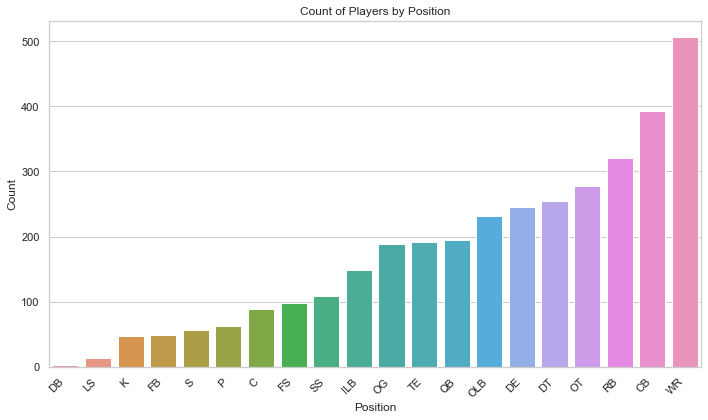

In [62]:
# Counting the occurrences of each position
position_counts = df['Position'].value_counts().sort_values(ascending=False)

# Setting Seaborn color palette
sns.set_palette("husl")

# Plotting the count of each position
plt.figure(figsize=(10, 6))
sns.barplot(x=position_counts.index, y=position_counts.values, order=position_counts.sort_values().index)
plt.title('Count of Players by Position')
plt.ylabel('Count')
plt.xlabel('Position')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

plt.tight_layout()  # Adjust layout to make room for rotated x-axis labels
plt.show()


<b>Drift Analysis by Year</b><br>We find that there is little fluctuation of average numerical metrics over the years.

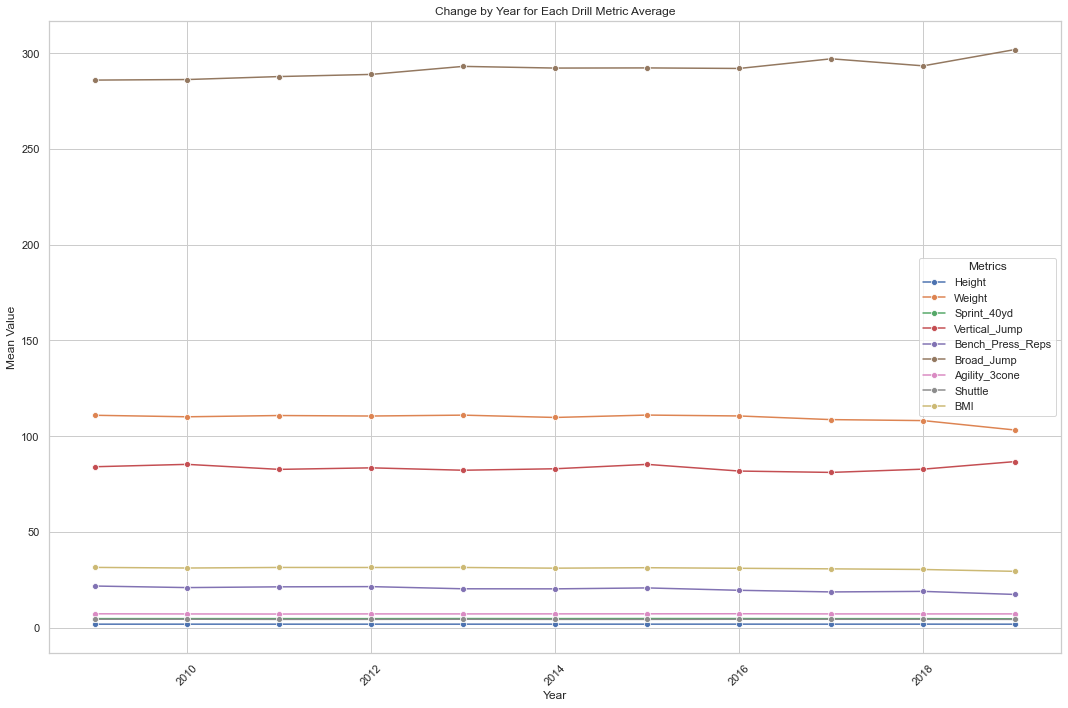

In [63]:
z_score_columns = ['Height', 'Weight', 'Sprint_40yd',
                   'Vertical_Jump', 'Bench_Press_Reps', 'Broad_Jump', 'Agility_3cone',
                   'Shuttle', 'BMI']

# Group by 'Year' and calculate the mean for each column
yearly_z_means = df.groupby('Year')[z_score_columns].mean().reset_index()

# Set the style for the plots
sns.set(style="whitegrid")

# Plot the change by year for each metric
plt.figure(figsize=(15, 10))

for col in z_score_columns:
    sns.lineplot(data=yearly_z_means, x='Year', y=col, marker='o', label=col)

plt.title('Change by Year for Each Drill Metric Average')
plt.xlabel('Year')
plt.ylabel('Mean Value')
plt.legend(title='Metrics')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<b>Data Imbalance in Target Variable</b><br>We find that there is imbalance in our target variable, which will need to be accounted for in the model pre-processing steps

Drafted Counts:
Yes    2254
No     1223
Name: Drafted, dtype: int64


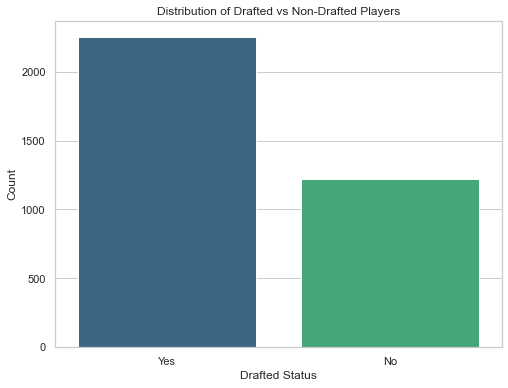

In [64]:
drafted_counts = df['Drafted'].value_counts()

# Step 2: Display the counts
print("Drafted Counts:")
print(drafted_counts)

# Step 3: Visualize the distribution using a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=drafted_counts.index, y=drafted_counts.values, palette='viridis')
plt.title('Distribution of Drafted vs Non-Drafted Players')
plt.xlabel('Drafted Status')
plt.ylabel('Count')
plt.show()

# 2. Data Cleaning

### Outlier Analysis

Identifying outliers is important to detect any value which is disproportionately high or small, to the extent which it would have to be removed from the data (5000 bench press reps for instance). We set our z-score threshold of 3 (values with + 3 or - 3 standard deviations from the mean). <br> 
* As a result, we do not find any significant discrepancies, and find that the variable with the highest number of outlier is <b>Age</b> which is strongly clustered around 22 years old (end of college). In most positions, very few players get drafted at 25 or more, or at 19 and below.<br>
* In terms, of <b>Bench-Press</b> reps and <b>BMI</b>, most upper bound outliers are <u>Defensive Tackles</u>. They tend to be the strongest and biggest players, so it is not inconsistent with our assumptions.
* Inversely,<u>Defensive Tackles</u>, <u>Offensive Guard</u>, <u>Offensive Tackles</u> seem to have, outliers underperforming in speed (upper bound), agility (upper bound), and jump drills (lower bound).
* <u>Corner Backs</u>, which tend to be physically smaller and more agile, have 1 overperforming outlier on the <b>vertical jump</b> (upper bound).

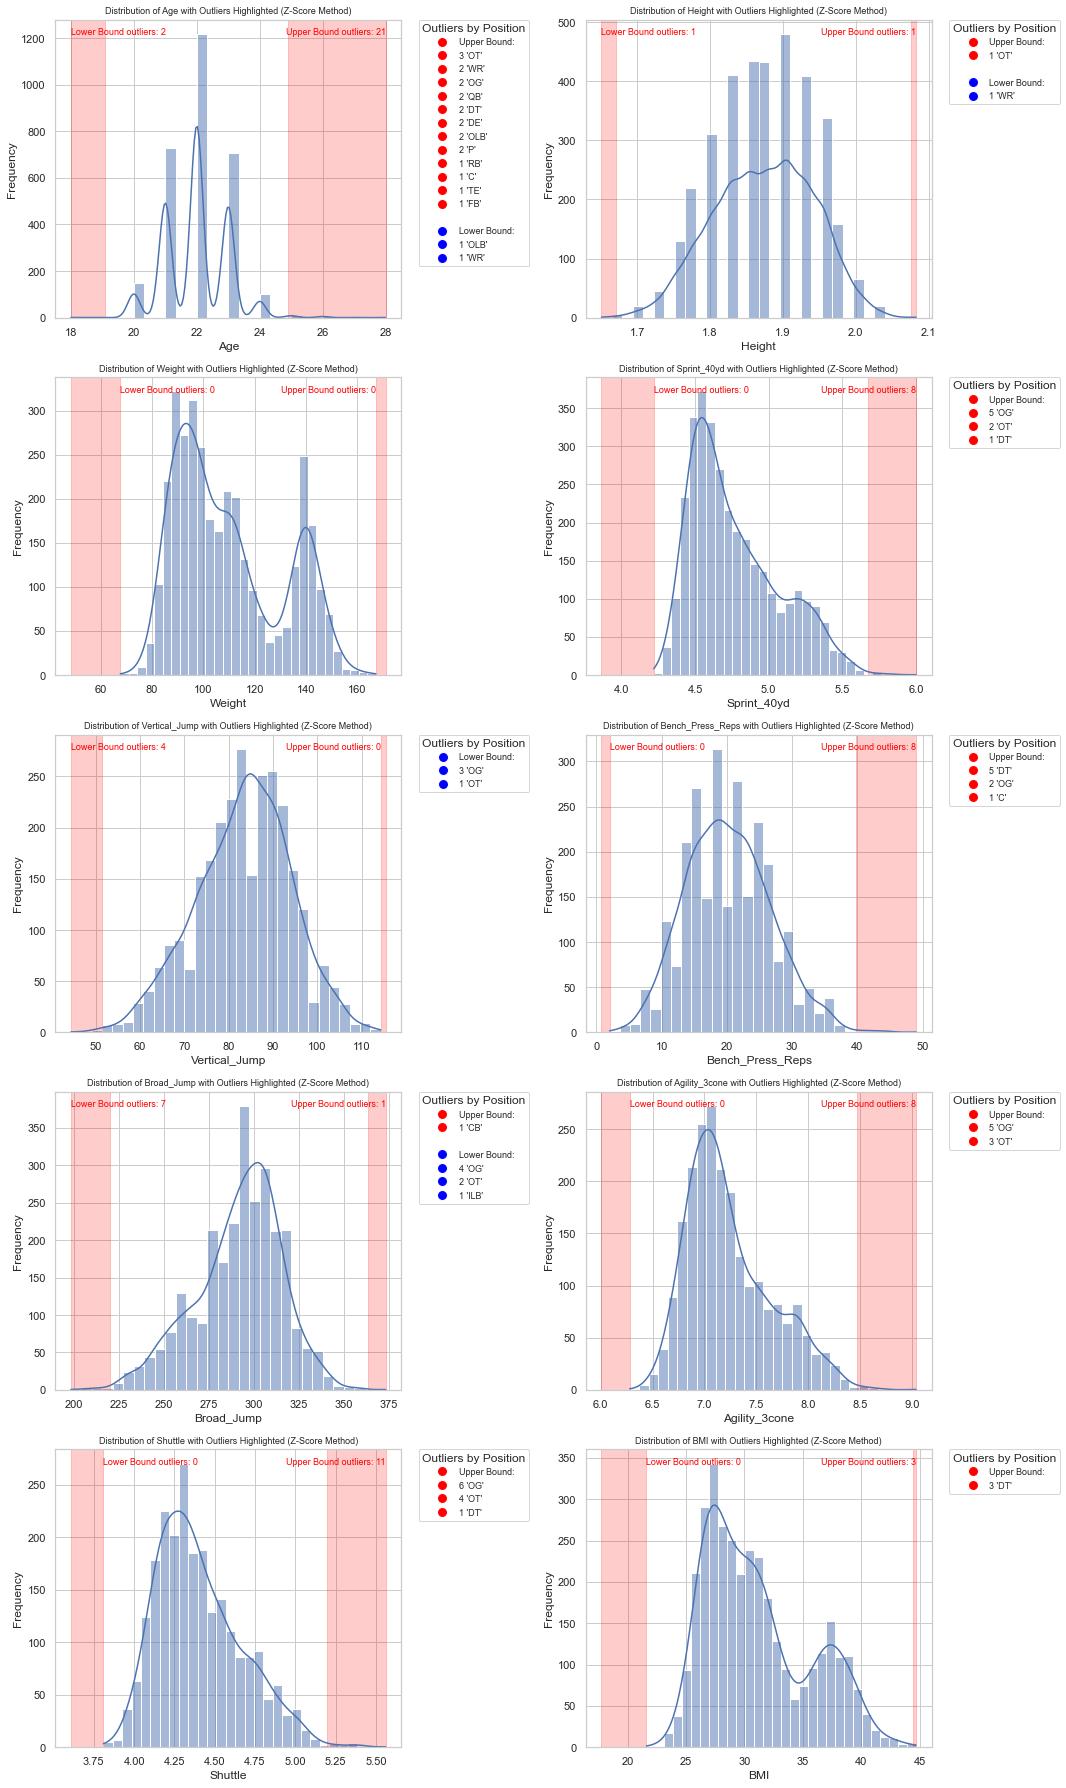

In [65]:
warnings.filterwarnings("ignore", category=FutureWarning, module="matplotlib.cbook")

# Select numerical columns, excluding 'Year'
num_cols = df.select_dtypes(include='number').columns
num_cols = num_cols[num_cols != 'Year']  # Exclude 'Year' column

# Set up the figure for subplots
n_cols = 2  # Number of columns for subplots
n_rows = len(num_cols) // n_cols + int(len(num_cols) % n_cols > 0)

plt.figure(figsize=(15, 5 * n_rows))

# Loop through each numerical variable and create a subplot
for i, col in enumerate(num_cols):
    # Calculate the mean and standard deviation, ignoring NaN values
    mean = np.nanmean(df[col].to_numpy())  # Convert to numpy array
    std_dev = np.nanstd(df[col].to_numpy())  # Convert to numpy array
    
    # Calculate the lower and upper bound values based on z-scores of -3 and 3
    lower = mean - 3 * std_dev
    upper = mean + 3 * std_dev
    
    # Identify and count outliers by position
    df['Upper_Bound_Outlier'] = df[col] >= upper
    df['Lower_Bound_Outlier'] = df[col] <= lower
    
    upper_outliers_count = df[df['Upper_Bound_Outlier']]['Position'].value_counts()
    lower_outliers_count = df[df['Lower_Bound_Outlier']]['Position'].value_counts()

    # Create subplot
    ax = plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df[col].dropna(), kde=True, ax=ax, bins=30)  # Drop NaN values for plotting

    # Highlighting the outliers
    ax.axvspan(xmin=df[col].min(), xmax=lower, alpha=0.2, color='red')
    ax.axvspan(xmin=upper, xmax=df[col].max(), alpha=0.2, color='red')

    # Adding text annotations for outlier counts
    ax.text(df[col].min(), ax.get_ylim()[1] * 0.95, f'Lower Bound outliers: {lower_outliers_count.sum()}', color='red', fontsize=9)
    ax.text(df[col].max(), ax.get_ylim()[1] * 0.95, f'Upper Bound outliers: {upper_outliers_count.sum()}', color='red', fontsize=9, horizontalalignment='right')

    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution of {col} with Outliers Highlighted (Z-Score Method)', fontsize=9)

    # Create custom legends for this graph
    legend_labels = []
    legend_patches = []
    
    if not upper_outliers_count.empty:
        upper_legend_labels = ['Upper Bound:'] + [f"{count} '{pos}'" for pos, count in upper_outliers_count.items()]
        legend_labels.extend(upper_legend_labels)
        legend_patches.extend([plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=10, markerfacecolor='red') for label in upper_legend_labels])
    
    if not lower_outliers_count.empty:
        if not upper_outliers_count.empty:
            legend_labels.append('')  # To ensure space between different legend sections if needed
            legend_patches.append(plt.Line2D([0], [0], color='w'))
        
        lower_legend_labels = ['Lower Bound:'] + [f"{count} '{pos}'" for pos, count in lower_outliers_count.items()]
        legend_labels.extend(lower_legend_labels)
        legend_patches.extend([plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=10, markerfacecolor='blue') for label in lower_legend_labels])
    
    if legend_labels:  # Only create a legend if there are labels to show
        ax.legend(handles=legend_patches, title='Outliers by Position', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=9)

plt.tight_layout()
plt.show()


### Formatting Errors

The <b> "Drafted..tm.rnd.yr." </b> contains information about the drafting team, round, pick rank, and year. Each value, if not null, has the following format: Arizona Cardinals / 1st / 31st pick / 2009. We clean this by separating this into 4 columns based on the "/" delimiter.

In [66]:
df[['Team','Round', "Pick", "Year"]] = df['Drafted..tm.rnd.yr.'].str.split('/',expand=True)

# Function to ensure only one space between words in each column
def normalize_spaces(s):
    if pd.isna(s):
        return s
    return ' '.join(s.split())

# Apply the function to each of the new columns
df['Team'] = df['Team'].apply(normalize_spaces)
df['Round'] = df['Round'].apply(normalize_spaces)
df['Pick'] = df['Pick'].apply(normalize_spaces)
df['Year'] = df['Year'].apply(normalize_spaces)

df = df.drop(columns=["Drafted..tm.rnd.yr."]) 

# Display the first few rows to verify the result
df[['Team', 'Round', 'Pick', 'Year']].head()

,Team,Round,Pick,Year
0,Arizona Cardinals,1st,31st pick,2009
1,Arizona Cardinals,6th,204th pick,2009
2,Arizona Cardinals,5th,167th pick,2009
3,Arizona Cardinals,3rd,95th pick,2009
4,Arizona Cardinals,2nd,63rd pick,2009


The <b> Round and Pick</b> columns are numerical and might provide relevant information. Let's remove all letters and convert them to numerical values:

In [67]:
def omit_letters(s):
    if pd.isna(s):
        return s
    return re.sub('[^0-9]','', s)
df['Round'] = df['Round'].apply(omit_letters)
df['Pick'] = df['Pick'].apply(omit_letters)
df['Pick'] = df['Pick'].astype(float).astype('Int64')
df['Round'] = df['Round'].astype(float).astype('Int64')

The <b> "Player" </b> column values are occasionaly formatted with the player name followed by a backslash, and what looks to be a Username: "Beanie Wells\WellCh00". To resolve this, we remove the backslash symbol and any set of string after.

In [68]:
def normalize_spaces(s):
    if pd.isna(s):
        return s
    return ' '.join(s.split())

# Step 3: Apply the function to the 'Player' column to normalize spaces
df['Player'] = df['Player'].apply(normalize_spaces)

df['Player'] = df['Player'].str.split('\\').str[0]
df['Player'].head()

0      Beanie Wells
1        Will Davis
2    Herman Johnson
3    Rashad Johnson
4        Cody Brown
Name: Player, dtype: object

For the sake of better visualization, we have each first letter of the <b> Player Type</b> column in upper case format

In [69]:
df['Player_Type'] = df['Player_Type'].str.title()

df['Player_Type'].head()

0    Offense
1    Defense
2    Offense
3    Defense
4    Defense
Name: Player_Type, dtype: object

Likewise, values in the <b> "Position_Types" </b> column are oddly formatted. Let's replace them with improved formatting:

In [70]:
df["Position_Type"].value_counts()

backs_receivers       1260
defensive_back         657
offensive_lineman      555
defensive_lineman      501
line_backer            380
kicking_specialist     111
other_special           13
Name: Position_Type, dtype: int64

In [71]:
# Define the mapping dictionary
position_type_mapping = {
    "backs_receivers": "Backs/Receivers",
    "defensive_back": "Defensive Back",
    "offensive_lineman": "Offensive Lineman",
    "defensive_lineman": "Defensive Lineman",
    "line_backer": "Linebacker",
    "kicking_specialist": "Kicking Specialist",
    "other_special": "Other Special"
}

# Apply the mapping to the Position_Type column
df["Position_Type"] = df["Position_Type"].replace(position_type_mapping)
df["Position_Type"].head()

0      Backs/Receivers
1    Defensive Lineman
2    Offensive Lineman
3       Defensive Back
4           Linebacker
Name: Position_Type, dtype: object

<b> Improved formatting for Positions

In [72]:
# Create a dictionary to map acronyms to full position names
position_mapping = {
    'RB': 'Running Back',
    'DE': 'Defensive End',
    'OG': 'Offensive Guard',
    'FS': 'Free Safety',
    'OLB': 'Outside Linebacker',
    'DT': 'Defensive Tackle',
    'OT': 'Offensive Tackle',
    'CB': 'Cornerback',
    'SS': 'Strong Safety',
    'TE': 'Tight End',
    'ILB': 'Inside Linebacker',
    'C': 'Center',
    'FB': 'Fullback',
    'WR': 'Wide Receiver',
    'P': 'Punter',
    'K': 'Kicker',
    'QB': 'Quarterback',
    'LS': 'Long Snapper',
    'S': 'Safety',
    'DB': 'Defensive Back'
}

# Replace the position acronyms in the 'Position' column with their full names
df['Position'] = df['Position'].map(position_mapping)
df['Position'].unique()

array(['Running Back', 'Defensive End', 'Offensive Guard', 'Free Safety',
       'Outside Linebacker', 'Defensive Tackle', 'Offensive Tackle',
       'Cornerback', 'Strong Safety', 'Tight End', 'Inside Linebacker',
       'Center', 'Fullback', 'Wide Receiver', 'Punter', 'Kicker',
       'Quarterback', 'Long Snapper', 'Safety', 'Defensive Back'],
      dtype=object)

<b> Let's drop irrelevant columns:

Year is a duplicate of the already existing "Year" column

In [73]:
#df = df.drop(columns=["Year"])

### Dealing with Null Values

<b> Team column:</b> The "Team" column has NAs for players with aren't drafted

In [74]:
df['Team'] = df['Team'].fillna("Not Drafted")


<b> Round column </b> let's create an arbitrary column for players which aren't drafted. Which will be used to find relationships with the drafted status.

In [75]:
df['Round'] = df['Round'].fillna(8)
df['Round'] = df['Round'].astype(int)
df['Round'].value_counts()

8    1223
3     361
4     356
5     337
1     329
2     328
6     284
7     259
Name: Round, dtype: int64

In [76]:
df.columns

Index(['Year', 'Player', 'Age', 'School', 'Height', 'Weight', 'Sprint_40yd',
       'Vertical_Jump', 'Bench_Press_Reps', 'Broad_Jump', 'Agility_3cone',
       'Shuttle', 'BMI', 'Player_Type', 'Position_Type', 'Position', 'Drafted',
       'Upper_Bound_Outlier', 'Lower_Bound_Outlier', 'Team', 'Round', 'Pick'],
      dtype='object')

#### <b> Multivariate Linear Regression to fill missing values </b>

<b>Method:</b> To fill in missing values for the 40 Yard Sprint, Vertical Jump, Broad Jump, Bench Press Reps, 3 Cone, and Shuttle drills, we decide to find the most highly correlated variables, and perform a multivariate linear regression to fill in the missing value.

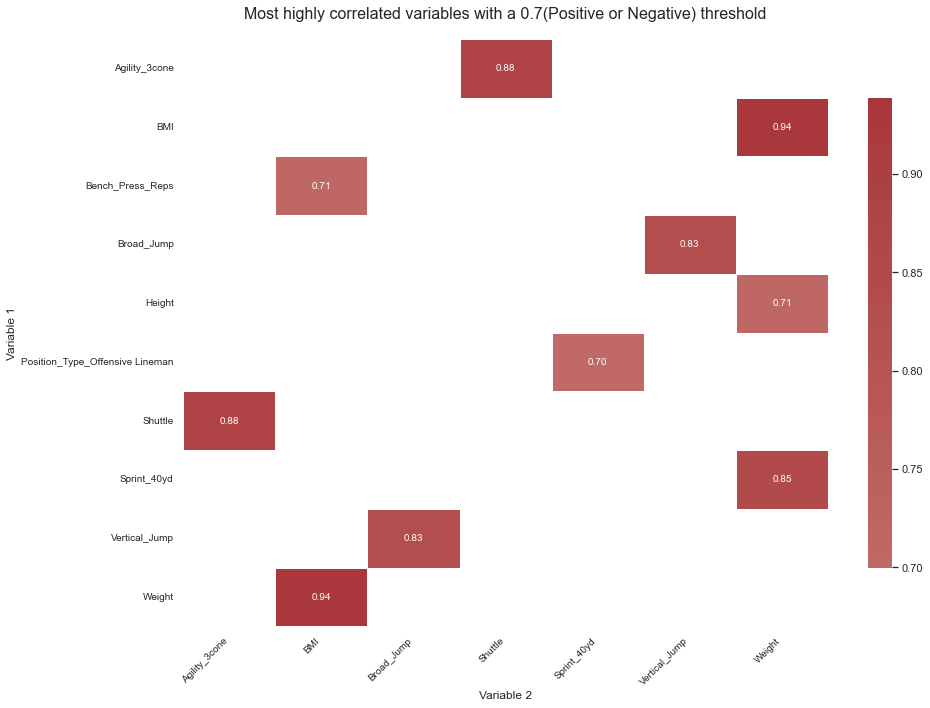

In [77]:
# Select the relevant columns including categorical ones
df_Regression = df.loc[:, ['Weight', 'Sprint_40yd', 'Bench_Press_Reps', 'Broad_Jump', 'Agility_3cone', 'Vertical_Jump', 'Shuttle', 'BMI', 'Height', 'Drafted', 'Position_Type', 'Position']]

# One-hot encode the categorical variables
df_encoded = pd.get_dummies(df_Regression, columns=['Position', 'Position_Type'])

# Remove stratified columns if any
df_encoded = df_encoded[[x for x in df_encoded if not x.endswith('_Strat')]]    

# Step 1: Identify correlated columns (without taking absolute values to preserve sign)
correlation_matrix = df_encoded.corr()

# Find pairs with an absolute correlation of 60% or more
high_corr_pairs = correlation_matrix.stack().reset_index()
high_corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']

# Remove self-correlation pairs (correlations with themselves)
high_corr_pairs = high_corr_pairs[high_corr_pairs['Variable 1'] != high_corr_pairs['Variable 2']]

# Identify one-hot encoded variables
one_hot_encoded_vars = [col for col in df_encoded.columns if col.startswith('Position_') or col.startswith('Drafted_')]

# Exclude pairs where both variables are one-hot encoded
high_corr_pairs = high_corr_pairs[
    ~((high_corr_pairs['Variable 1'].isin(one_hot_encoded_vars)) & (high_corr_pairs['Variable 2'].isin(one_hot_encoded_vars)))
]

# Filter out correlations that are exactly 1 or -1 and keep only those with |Correlation| >= 0.6
high_corr_pairs = high_corr_pairs[(high_corr_pairs['Correlation'].abs() >= 0.6) & (high_corr_pairs['Correlation'].abs() < 1.0)]

# Sort by the absolute value of the correlation in descending order
high_corr_pairs = high_corr_pairs.sort_values(by='Correlation', ascending=False)

# Keep only the highest absolute correlation for each unique Variable 1
unique_high_corr_pairs = high_corr_pairs.groupby('Variable 1').first().reset_index()

# Pivot the data for heatmap visualization
pivot_table = unique_high_corr_pairs.pivot(index='Variable 1', columns='Variable 2', values='Correlation')

# Plot the heatmap using Seaborn
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_table, annot=True, cmap='vlag', center=0, linewidths=1, linecolor='white', cbar_kws={'shrink': 0.8}, fmt='.2f', annot_kws={'size': 10})

# Customize the heatmap for better visual appeal
plt.title('Most highly correlated variables with a 0.7(Positive or Negative) threshold', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


<b>3D Multivariate Regression Illustration:</b> If Weight is missing, then we can select 2 explanatory variables for prediction

Intercept:  -217.4600351686638
Coefficients array:  [112.67145438   1.34909068   3.52804738]
R² Score: 0.9980453250482845


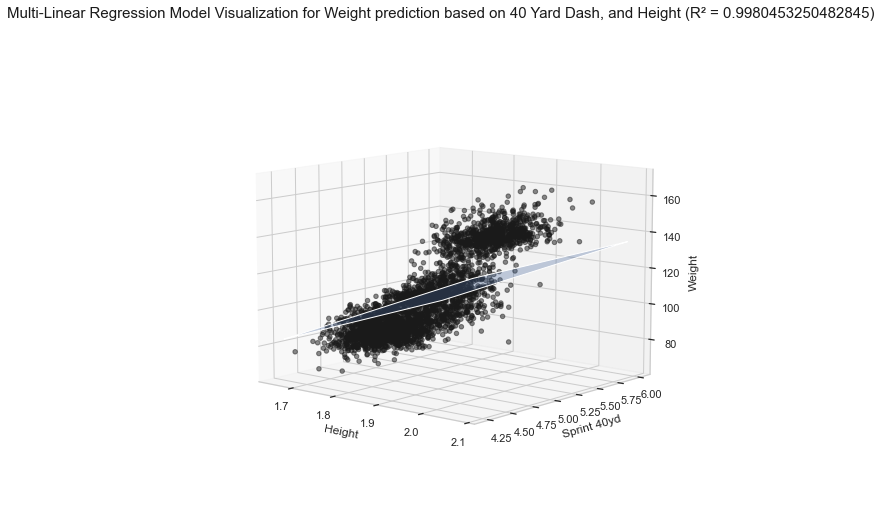

In [78]:
# Drop rows where any of the relevant columns are missing
df_clean = df.dropna(subset=['Height', 'Sprint_40yd', 'BMI', 'Weight'])

# Preparing the independent (Height, Sprint_40yd, BMI) and dependent (Weight) variables
X = df_clean[['Height', 'Sprint_40yd', 'BMI']].values
y = df_clean['Weight'].values

# Initializing and fitting the linear regression model
reg = LinearRegression()
reg.fit(X, y)

# Printing the intercept and coefficients
print('Intercept: ', reg.intercept_)
print('Coefficients array: ', reg.coef_)

# Calculating the R² score for the model
r2 = reg.score(X, y)
print(f'R² Score: {r2}')

# Preparing data for visualization
# Note the correct order based on how X was created: ['Height', 'Sprint_40yd', 'BMI']
height = X[:, 0]         # Height is the first column in X
sprint_40yd = X[:, 1]    # Sprint_40yd is the second column in X
bmi = X[:, 2]            # BMI is the third column in X
weight = y               # Weight is the dependent variable

# Creating a grid for the prediction surface
height_range = np.linspace(height.min(), height.max(), 50)
sprint_40yd_range = np.linspace(sprint_40yd.min(), sprint_40yd.max(), 50)
height_grid, sprint_40yd_grid = np.meshgrid(height_range, sprint_40yd_range)
prediction_grid = np.array([height_grid.flatten(), sprint_40yd_grid.flatten(), np.mean(bmi) * np.ones_like(height_grid.flatten())]).T

# Predicting Weight values using the regression model
weight_predictions = reg.predict(prediction_grid).reshape(height_grid.shape)

# Plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotting the original data points
ax.scatter(height, sprint_40yd, weight, color='k', zorder=10, marker='o', alpha=0.5, label='Data Points')

# Plotting the regression plane
ax.plot_surface(height_grid, sprint_40yd_grid, weight_predictions, color='b', alpha=0.3, rstride=100, cstride=100)

# Setting labels
ax.set_xlabel('Height')
ax.set_ylabel('Sprint 40yd')
ax.set_zlabel('Weight')

# Setting a good viewing angle
ax.view_init(elev=10, azim=-50)

# Adding the title with the R² score
fig.suptitle(f'Multi-Linear Regression Model Visualization for Weight prediction based on 40 Yard Dash, and Height (R² = {r2})', fontsize=15, color='k')

plt.show()



<b> Multivariate linear Regression</b>: <br><br> We use multivariate <b> Linear Regression model</b> to replace null values. For each missing value within q numerical variable column, we find all the numerical variables which: 
1. Are non-null 
2. Have a strong correlation (positive or negative)

We also hot-one encode the categorical variables, and identify the most highly correlated values. Offensive linemen have a strong relationship with some of the numerical feature, so we include them to the regression model in order to predict the missing values.

In [79]:
# Select the relevant columns including categorical ones
df_Regression = df.loc[:, ['Weight', 'Sprint_40yd', 'Bench_Press_Reps', 'Broad_Jump', 'Agility_3cone', 'Vertical_Jump', 'Shuttle', 'BMI', 'Height', 'Drafted', 'Position_Type']]

# One-hot encode the categorical variables
df_encoded = pd.get_dummies(df_Regression, columns=['Drafted', 'Position_Type'])

#Remove strats
df_encoded = df_encoded[[x for x in df_encoded if not x.endswith('_Strat')]]    
# Step 1: Identify highly correlated columns
correlation_matrix = df_encoded.corr().abs()

# We want to find pairs with a correlation of 70% or more
high_corr_pairs = correlation_matrix.stack().reset_index()
high_corr_pairs = high_corr_pairs[high_corr_pairs['level_0'] != high_corr_pairs['level_1']]
high_corr_pairs = high_corr_pairs[high_corr_pairs[0] >= 0.6]

# Step 2: Function to predict and fill missing values using multiple explanatory variables
def fill_missing_values_multivariable(df, col_to_fill, explanatory_vars):
    # One hot encoding categorical variables to include in the predictor
    df = pd.get_dummies(df, columns=['Drafted', 'Position_Type'])
    # Separate the data into those with and without missing values
    non_null_df = df[df[col_to_fill].notnull()]
    null_df = df[df[col_to_fill].isnull()]
    # If there's no missing value, return the column as is
    if null_df.empty:
        return df[col_to_fill]
    
    # Ensure that we only use explanatory variables that are not null
    explanatory_vars = [var for var in explanatory_vars if var in df.columns and df[var].isnull().sum() == 0]
    
    
    # Train a linear regression model on non-null data
    X_train = non_null_df[explanatory_vars]
    y_train = non_null_df[col_to_fill]
    X_train
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict the missing values
    X_predict = null_df[explanatory_vars]
    y_predict = model.predict(X_predict)
    
    # Fill the missing values with the predictions
    df.loc[df[col_to_fill].isnull(), col_to_fill] = y_predict
    
    return df[col_to_fill]

# Step 3: Apply the model to fill missing values for each column
columns_to_predict = ['Shuttle', 'Height', 'Weight', 'Sprint_40yd', 'Vertical_Jump', 'Bench_Press_Reps', 'Broad_Jump', 'Agility_3cone']

for col in columns_to_predict:
    explanatory_vars = [c for c in columns_to_predict if c != col]
    df[col] = fill_missing_values_multivariable(df, col, explanatory_vars)

# Display the DataFrame after filling missing values
df = df[[x for x in df if not x.endswith('_Strat')]]  
df[['Sprint_40yd', 'Vertical_Jump', 'Bench_Press_Reps', 'Broad_Jump', 'Agility_3cone', 'Shuttle']].isnull().sum()

Sprint_40yd         0
Vertical_Jump       0
Bench_Press_Reps    0
Broad_Jump          0
Agility_3cone       0
Shuttle             0
dtype: int64

#### <b>Age Column</b>

<b>Method:</b> Replacing Age null by position Mean Age

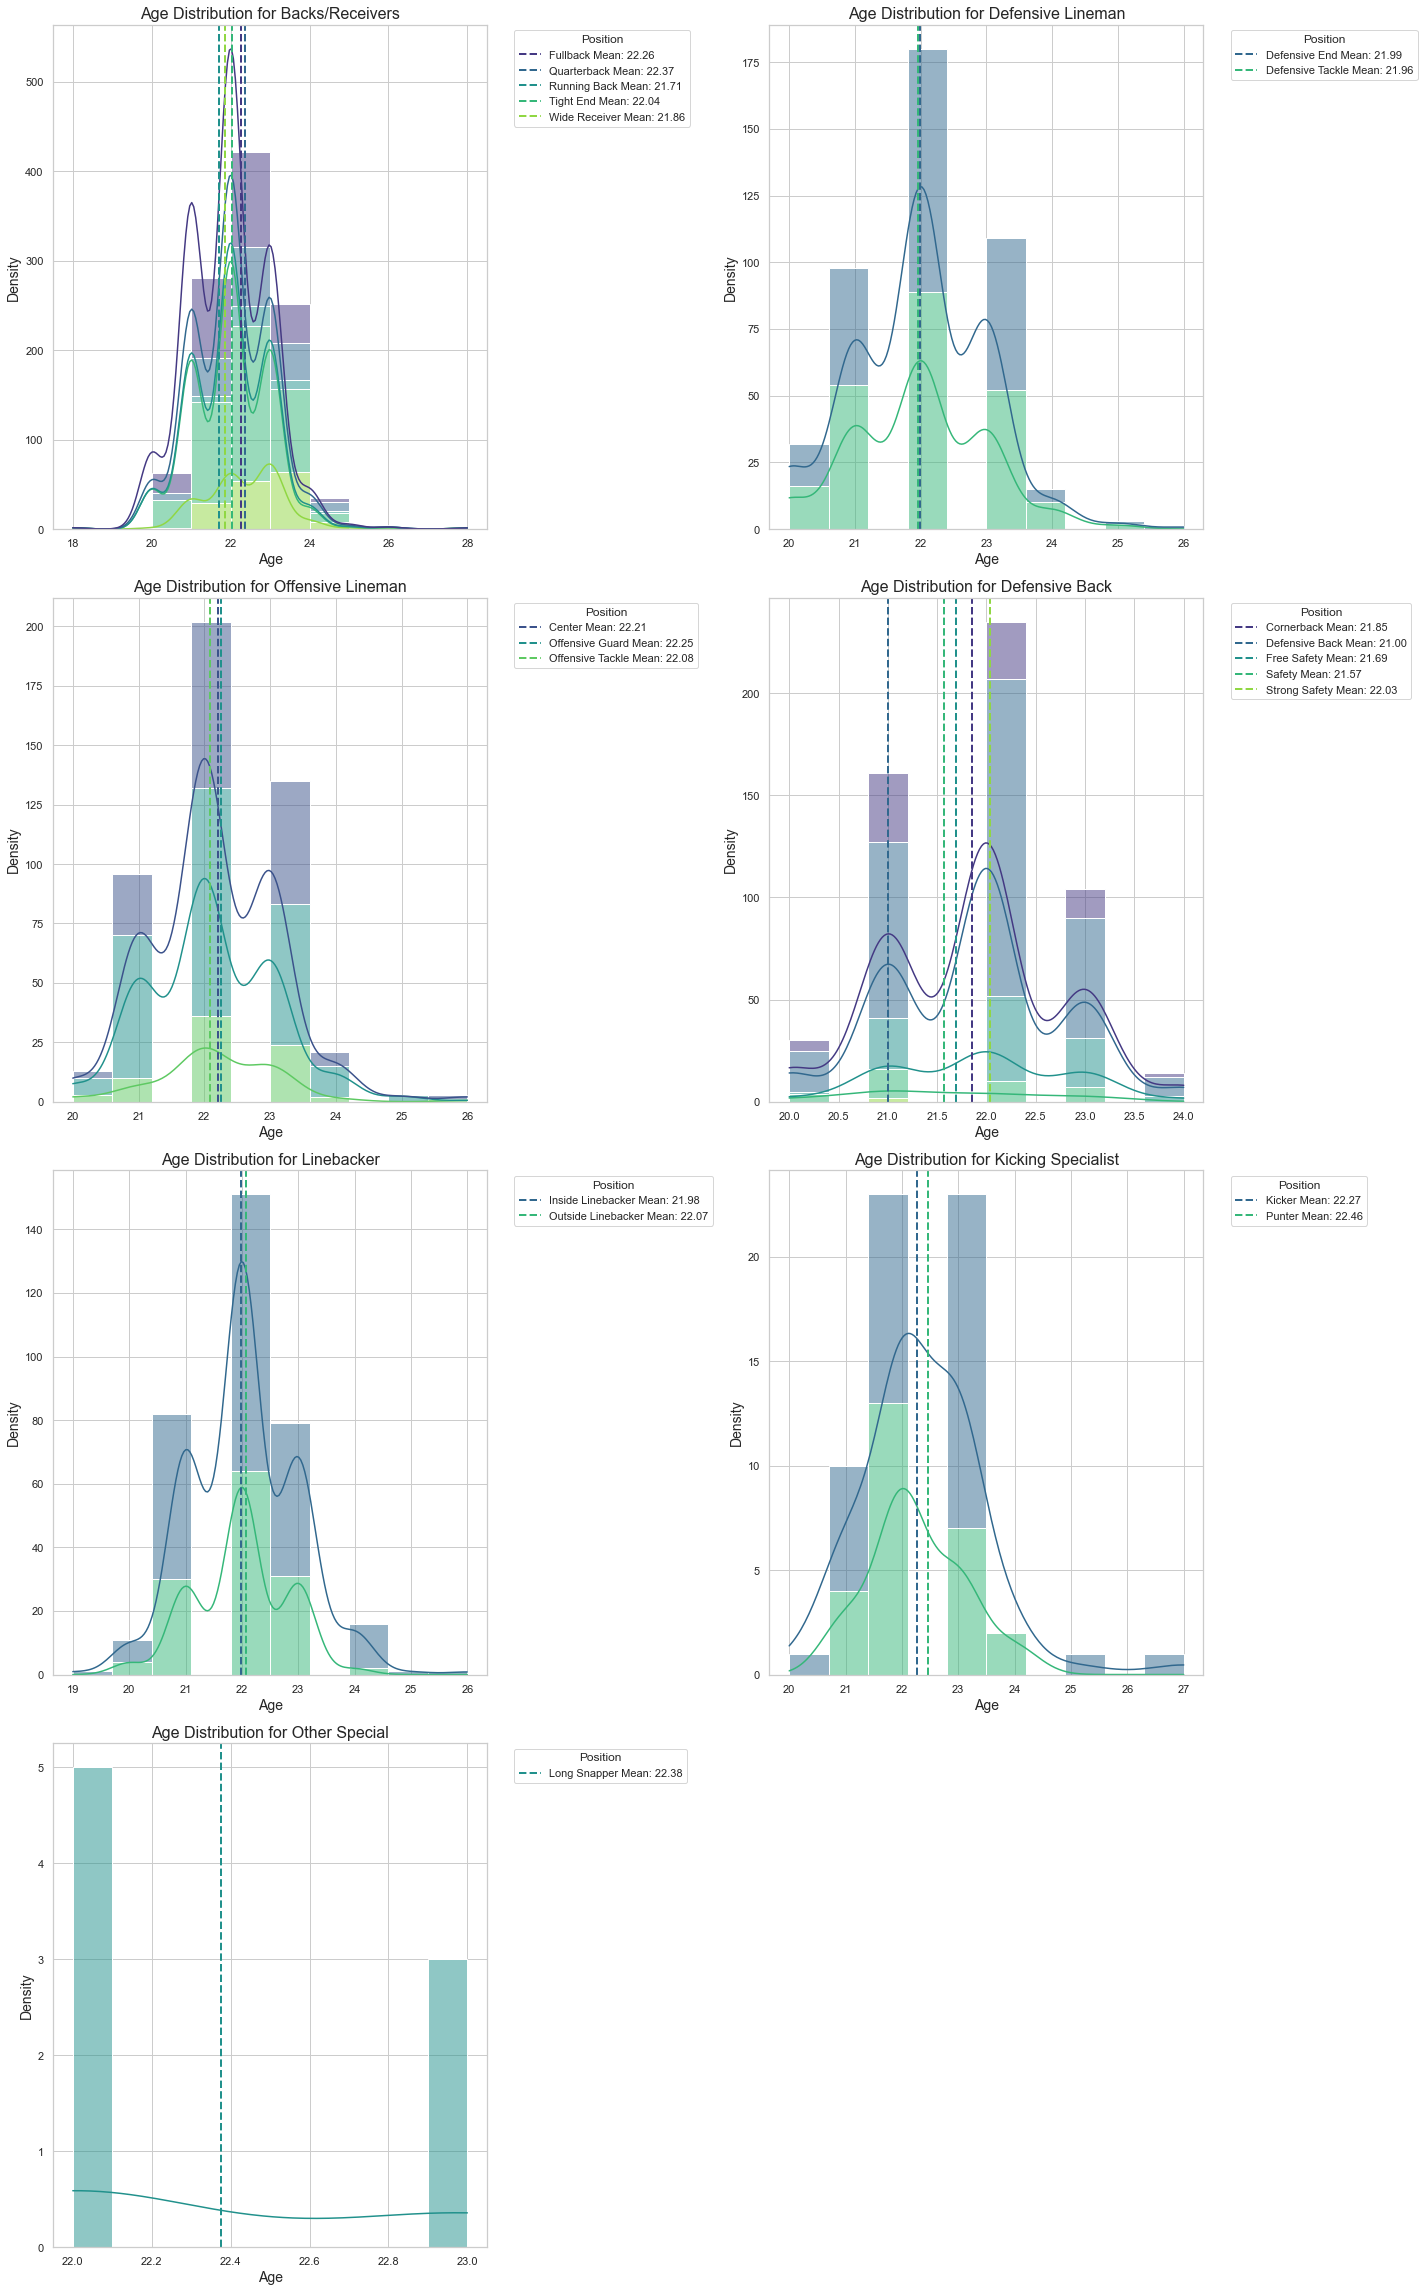

In [80]:
sns.set(style="whitegrid")

# Step 1: Get unique position types
position_types = df['Position_Type'].unique()
num_positions = len(position_types)

# Step 2: Set up the plot grid (2 plots per row)
plt.figure(figsize=(20, (num_positions // 2 + 1) * 8))

# Step 3: Loop through each Position_Type and create a distribution plot
for i, position_type in enumerate(position_types):
    plt.subplot((num_positions + 1) // 2, 2, i + 1)
    subset = df[df['Position_Type'] == position_type]
    
    # Plot the distribution of ages with hue based on Position
    sns.histplot(subset, x='Age', hue='Position', kde=True, bins=10, palette='viridis', multiple='stack')
    
    # Calculate and plot the mean age for each position
    mean_age = subset.groupby('Position')['Age'].mean()
    palette = sns.color_palette('viridis', n_colors=len(mean_age))
    for j, (pos, mean) in enumerate(mean_age.items()):
        plt.axvline(mean, linestyle='dashed', linewidth=2, color=palette[j], label=f'{pos} Mean: {mean:.2f}')
    
    # Add title and labels
    plt.title(f'Age Distribution for {position_type}', fontsize=16)
    plt.xlabel('Age', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    
    # Add a legend in each plot
    plt.legend(title='Position', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to ensure it fits well
plt.tight_layout()
plt.show()


Except for DBs, who have a mean closer to 21, all other missing players are assigned with 22 years old

In [81]:
# Step 1: Calculate the mean age by position
mean_age_by_position = df.groupby('Position')['Age'].mean().round().reset_index()

# Step 2: Merge this mean age back into the original DataFrame
df = df.merge(mean_age_by_position, on='Position', suffixes=('', '_Position_Avg'))

# Step 3: Fill in the NAs in 'Age' with the corresponding 'Position_Avg' and round to the nearest integer
df['Age'] = df['Age'].fillna(df['Age_Position_Avg']).round()

# Step 4: Drop the 'Age_Position_Avg' column as it's no longer needed
df = df.drop(columns=['Age_Position_Avg'])


# Exploratory Data Analysis

### Correlation Analysis and Collinearity

#### <b>Numerical Variables</b><br><br>
We find that drills using similar skills have a strong positive relationship (Broad Jump and Vertical Jump for instance). For instance, Good Performance (positive of negative relationship depending on the drill) in agility drills, also indicates a good performance in speed drills and jump drills. However, good performance on the Bench Press will tend to negatively impact speed, agility, and jump drills, since weight and Bench Press performance are related, and since weight negatively affects these drills.

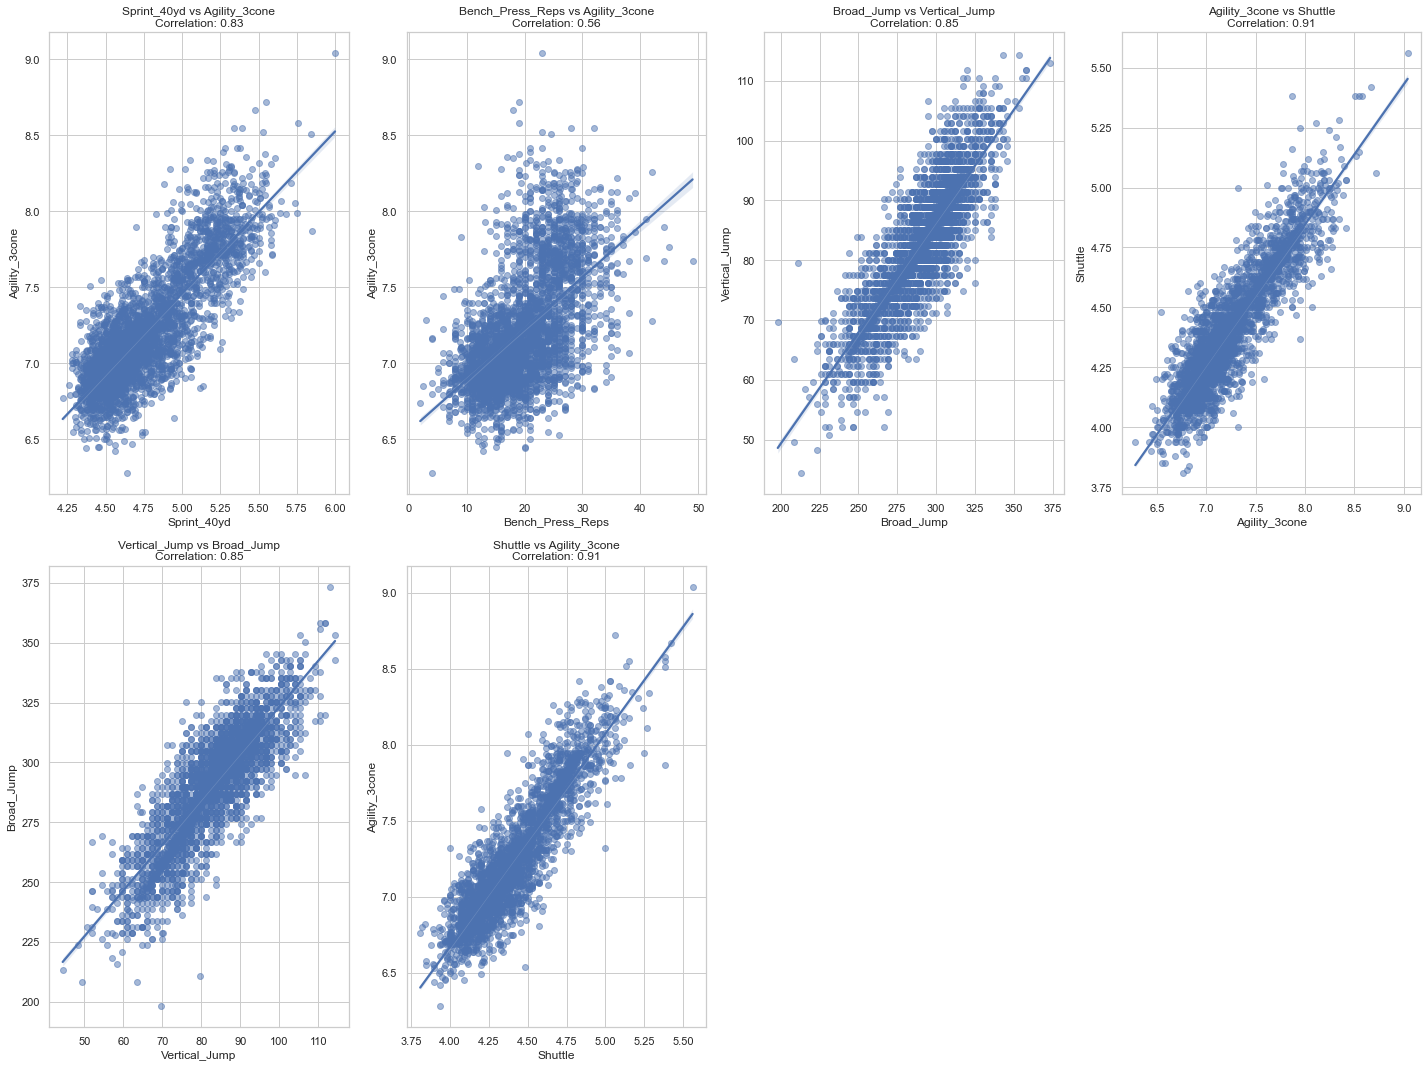

In [82]:

numerical_columns = ['Sprint_40yd', 'Bench_Press_Reps', 'Broad_Jump', 'Agility_3cone', 'Vertical_Jump', 'Shuttle']

# List of one-hot encoded columns (assuming they start with 'Position_' or 'Drafted_')
encoded_columns = [col for col in df.columns if col.startswith('Position') or col.startswith('Drafted_')]

# Combine numerical and encoded columns
all_columns = numerical_columns + encoded_columns

# Calculate the correlation matrix for the combined columns
correlation_matrix = df[all_columns].corr()

# Find the variable with the highest correlation for each variable
highest_correlation = {}
for col in correlation_matrix.columns:
    # Exclude self-correlation by setting it to NaN
    correlation_matrix.loc[col, col] = np.nan
    # Find the maximum correlation value and its corresponding variable
    max_corr_value = correlation_matrix[col].max()
    max_corr_var = correlation_matrix[col].idxmax()
    highest_correlation[col] = (max_corr_var, max_corr_value)

# Convert the result to a DataFrame for better visualization
highest_correlation_df = pd.DataFrame(highest_correlation, index=['Most Correlated Variable', 'Correlation Coefficient']).T

# Create a grid of reg plots (4 plots per row)
num_vars = len(highest_correlation_df)
fig, axes = plt.subplots((num_vars + 3) // 4, 4, figsize=(20, 15))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plotting each pair using regplot
for i, (var, row) in enumerate(highest_correlation_df.iterrows()):
    most_corr_var = row['Most Correlated Variable']
    sns.regplot(data=df, x=var, y=most_corr_var, ax=axes[i], scatter_kws={'alpha': 0.5})
    axes[i].set_title(f'{var} vs {most_corr_var}\nCorrelation: {row["Correlation Coefficient"]:.2f}')
    axes[i].grid(True)

# Hide any remaining empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


#### <b> Numerical and Categorical Variables </b>

<b>Offensive Lineman</b> Positions show very strong relationships with the numerical variables, especially 40 yard dash. This indicates that the position tends to excel in terms of Bench Press Reps performance, but be the worst performing position type in any other drill.

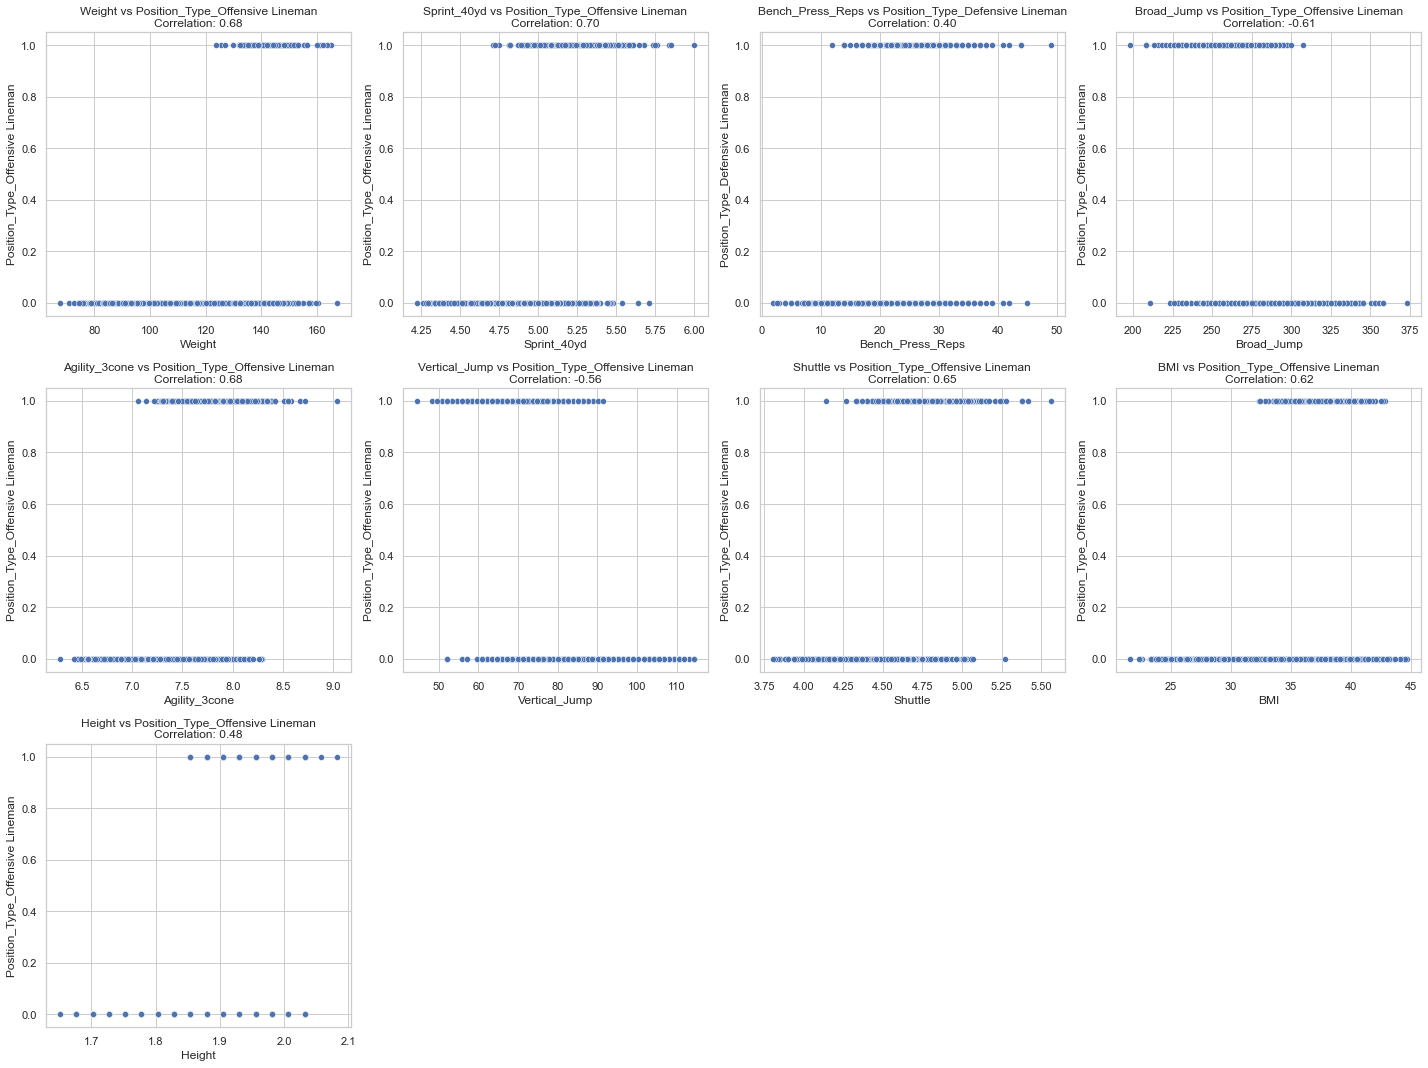

In [83]:

# Select the relevant columns including categorical ones
df_encoded = df.loc[:, ['Weight', 'Sprint_40yd', 'Bench_Press_Reps', 'Broad_Jump', 'Agility_3cone', 'Vertical_Jump', 'Shuttle', 'BMI', 'Height', 'Drafted', 'Position_Type']]

# One-hot encode the categorical variables
df_encoded = pd.get_dummies(df_encoded, columns=['Drafted', 'Position_Type'])

# Calculate the correlation matrix
correlation_matrix = df_encoded.corr()

# Filter for correlations between numerical and one-hot encoded variables
# Extracting correlations for the numerical variables with any "Drafted_" or "Position_" variables
numerical_columns = ['Weight', 'Sprint_40yd', 'Bench_Press_Reps', 'Broad_Jump', 'Agility_3cone', 'Vertical_Jump', 'Shuttle', 'BMI', 'Height']
encoded_columns = [col for col in df_encoded.columns if col.startswith('Drafted_') or col.startswith('Position_')]

# Find the highest correlation for each numerical variable with any one-hot encoded variable
highest_correlation = {}
for num_col in numerical_columns:
    max_corr_value = None
    max_corr_var = None
    for enc_col in encoded_columns:
        corr_value = correlation_matrix.loc[num_col, enc_col]
        if max_corr_value is None or abs(corr_value) > abs(max_corr_value):
            max_corr_value = corr_value
            max_corr_var = enc_col
    highest_correlation[num_col] = (max_corr_var, max_corr_value)

# Convert the result to a DataFrame for better visualization
highest_correlation_df = pd.DataFrame(highest_correlation, index=['Most Correlated Variable', 'Correlation Coefficient']).T

# Create a grid of plots (4 plots per row)
num_vars = len(highest_correlation_df)
fig, axes = plt.subplots((num_vars + 3) // 4, 4, figsize=(20, 15))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plotting each pair
for i, (var, row) in enumerate(highest_correlation_df.iterrows()):
    most_corr_var = row['Most Correlated Variable']
    sns.scatterplot(data=df_encoded, x=var, y=most_corr_var, ax=axes[i])
    axes[i].set_title(f'{var} vs {most_corr_var}\nCorrelation: {row["Correlation Coefficient"]:.2f}')
    axes[i].grid(True)

# Hide any remaining empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


#### <b> Categorical variables</b>

Using the Chi-Square method, we find that Schools, Player Type, Position Type, and Position will be significant factors on whether a player gets drafted

In [54]:

# Identify categorical variables
df_cat = pd.DataFrame(data=df.dtypes, columns=['dtype']).reset_index()
cat_var = list(df_cat['index'].loc[df_cat['dtype'] == 'object'])
df_cat_v1 = df[cat_var].dropna()

# Define pairs of categorical variables
cat_var1 = ('School', 'Player_Type', 'Position_Type', 'Position', 'Drafted')
cat_var2 = ('School', 'Player_Type', 'Position_Type', 'Position', 'Drafted')

# Generate all possible combinations between the variables
cat_var_prod = list(product(cat_var1, cat_var2, repeat=1))
result = []

# Perform Chi-Square test for each pair and store the p-values
for i in cat_var_prod:
    if i[0] != i[1]:
        # Compute the chi-squared test
        chi2, p, dof, ex = ss.chi2_contingency(pd.crosstab(df_cat_v1[i[0]], df_cat_v1[i[1]]))
        significance = 1 if p < 0.05 else 0  # Use numeric values 1 and 0
        result.append((i[0], i[1], p, significance))

# Convert the result to a DataFrame
chi_test_output = pd.DataFrame(result, columns=['var1', 'var2', 'p_value', 'Significant'])

# Pivot the results to create a matrix for the heatmap
chi_test_pivot = chi_test_output.pivot(index='var1', columns='var2', values='Significant')

# Create a corresponding annotation matrix with "Yes" or "No"
annotation_matrix = chi_test_pivot.applymap(lambda x: 'Yes' if x == 1 else 'No')

# Plot the heatmap using Seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(chi_test_pivot, annot=annotation_matrix, cmap='coolwarm', cbar=False, linewidths=0.5, fmt='')

# Customize the heatmap
plt.title('Is the Chi-Square Test Significant (p-value < 0.05)?', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Display the heatmap
plt.show()


KeyError: 'School'

#### <b>Multicollinearity Solution</b> 

To deal with collinearity, we create a weighted score for speed, agility, and strength drills (Bench press Reps only), and weight them between 0 and 1, and apply them to each Player.

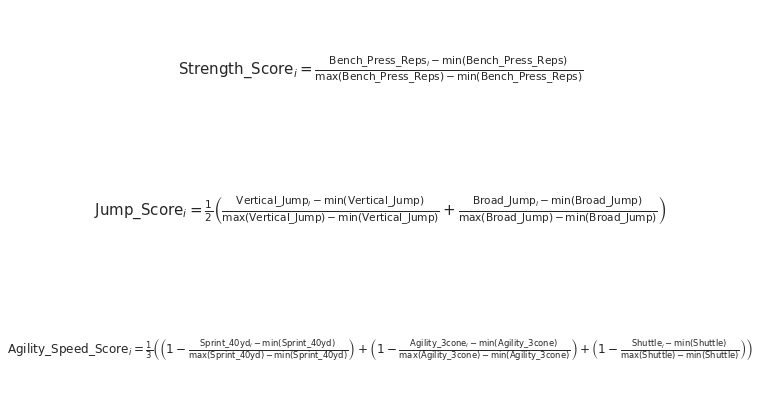

In [31]:

# Normalize a column to a 0-1 scale
def normalize_column(df, column_name):
    return (df[column_name] - df[column_name].min()) / (df[column_name].max() - df[column_name].min())

# Create Strength Score
df['Strength_Score'] = normalize_column(df, 'Bench_Press_Reps')

# Create Jump Score by averaging the normalized Vertical Jump and Broad Jump
df['Jump_Score'] = (normalize_column(df, 'Vertical_Jump') + normalize_column(df, 'Broad_Jump')) / 2

# Create Agility & Speed Score by averaging the normalized Agility 3 cone, 40 yard sprint, and Shuttle
# For sprint times and agility, lower values are better, so we subtract the normalized values from 1
df['Agility_Speed_Score'] = (1 - normalize_column(df, 'Sprint_40yd') + 
                              1 - normalize_column(df, 'Agility_3cone') + 
                              1 - normalize_column(df, 'Shuttle')) / 3

# Define the mathematical equations as strings using \mathrm for text
strength_score_eq = r"$\mathrm{Strength\_Score}_i = \frac{\mathrm{Bench\_Press\_Reps}_i - \min(\mathrm{Bench\_Press\_Reps})}{\max(\mathrm{Bench\_Press\_Reps}) - \min(\mathrm{Bench\_Press\_Reps})}$"

jump_score_eq = r"$\mathrm{Jump\_Score}_i = \frac{1}{2} \left( \frac{\mathrm{Vertical\_Jump}_i - \min(\mathrm{Vertical\_Jump})}{\max(\mathrm{Vertical\_Jump}) - \min(\mathrm{Vertical\_Jump})} + \frac{\mathrm{Broad\_Jump}_i - \min(\mathrm{Broad\_Jump})}{\max(\mathrm{Broad\_Jump}) - \min(\mathrm{Broad\_Jump})} \right)$"

agility_speed_score_eq = r"$\mathrm{Agility\_Speed\_Score}_i = \frac{1}{3} \left( \left( 1 - \frac{\mathrm{Sprint\_40yd}_i - \min(\mathrm{Sprint\_40yd})}{\max(\mathrm{Sprint\_40yd}) - \min(\mathrm{Sprint\_40yd})} \right) + \left( 1 - \frac{\mathrm{Agility\_3cone}_i - \min(\mathrm{Agility\_3cone})}{\max(\mathrm{Agility\_3cone}) - \min(\mathrm{Agility\_3cone})} \right) + \left( 1 - \frac{\mathrm{Shuttle}_i - \min(\mathrm{Shuttle})}{\max(\mathrm{Shuttle}) - \min(\mathrm{Shuttle})} \right) \right)$"

# Create a figure and axis with white background
fig, axes = plt.subplots(3, 1, figsize=(10, 6))
fig.patch.set_facecolor('white')

# Display each equation on its own subplot
axes[0].text(0.5, 0.5, strength_score_eq, fontsize=15, ha='center', va='center')
axes[0].axis('off')

axes[1].text(0.5, 0.5, jump_score_eq, fontsize=15, ha='center', va='center')
axes[1].axis('off')

axes[2].text(0.5, 0.5, agility_speed_score_eq, fontsize=12, ha='center', va='center')
axes[2].axis('off')

plt.tight_layout()
plt.show()


# Feature Engineering and Visualization

### Best Athletic Feature by Position

#### <b> Metric for Overall Athleticism</b>

To determine the overall athleticism for each player, we find the average of the Strength, Jump, and Agility score

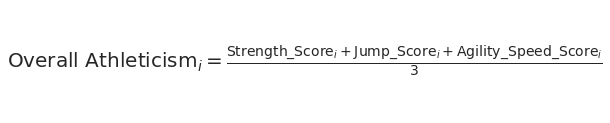

In [32]:

# List of the columns to analyze
scores = ['Strength_Score', 'Jump_Score', 'Agility_Speed_Score']
df['Overall_Athleticism'] = df[scores].mean(axis=1)

plt.figure(figsize=(8, 2), facecolor='white')

# Add the equation as text to the plot using \mathrm for text
plt.text(0.5, 0.5, r'$\mathrm{Overall\ Athleticism}_i = \frac{\mathrm{Strength\_Score}_i + \mathrm{Jump\_Score}_i + \mathrm{Agility\_Speed\_Score}_i}{3}$',
         horizontalalignment='center',
         verticalalignment='center',
         fontsize=20)
# Remove axes for a clean look
plt.axis('off')
# Display the equation
plt.show()

#### <b>Position-Specific:</b> Best Athleticism

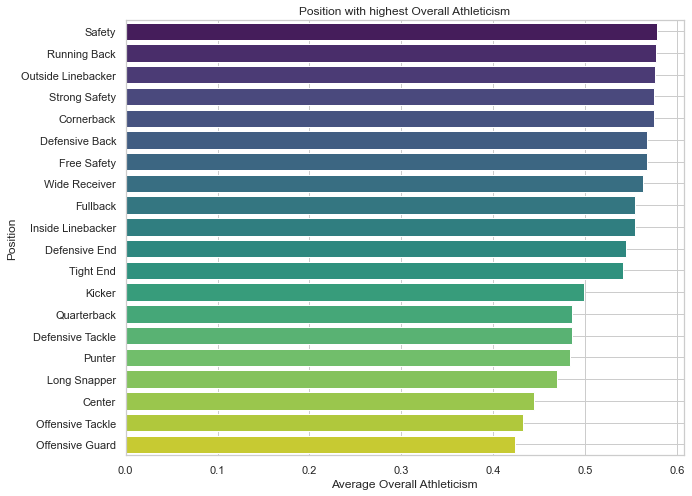

In [33]:
# Group by 'Position_Type' and calculate the mean of the 'Composite_Score_Player' for each position
position_composite_means = df.groupby('Position')['Overall_Athleticism'].mean().reset_index()

# Sort the positions by their average composite score in descending order
position_composite_means = position_composite_means.sort_values(by='Overall_Athleticism', ascending=False)

# Optional: Highlighting positions in the original DataFrame by merging the average composite score back to the original DataFrame
df = df.merge(position_composite_means, on='Position', suffixes=('', '_Position_Avg'))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw a seaborn barplot
sns.barplot(x='Overall_Athleticism', y='Position', data=position_composite_means, palette='viridis')

plt.xlabel('Average Overall Athleticism')
plt.ylabel('Position')
plt.title('Position with highest Overall Athleticism')
plt.grid(True)

plt.show()

#### <b>Position-Specific:</b> Strongest

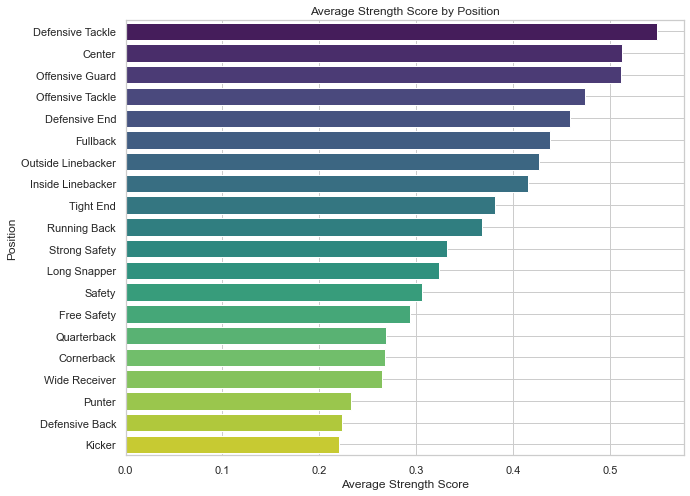

In [34]:
# Group by 'Position_Type' and calculate the mean of the 'Composite_Score_Player' for each position
position_strength_means = df.groupby('Position')['Strength_Score'].mean().reset_index()

# Sort the positions by their average composite score in descending order
position_strength_means = position_strength_means.sort_values(by='Strength_Score', ascending=False)

df = df.merge(position_strength_means, on='Position', suffixes=('', '_Position_Avg'))
# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw a seaborn barplot for Strength Score
sns.barplot(x='Strength_Score', y='Position', data=position_strength_means, palette='viridis')

plt.xlabel('Average Strength Score')
plt.ylabel('Position')
plt.title('Average Strength Score by Position')
plt.grid(True)

plt.show()



#### <b>Position Specific:</b> Most Agile and Fastest

* Find team with highest average athleticism based on the position specific

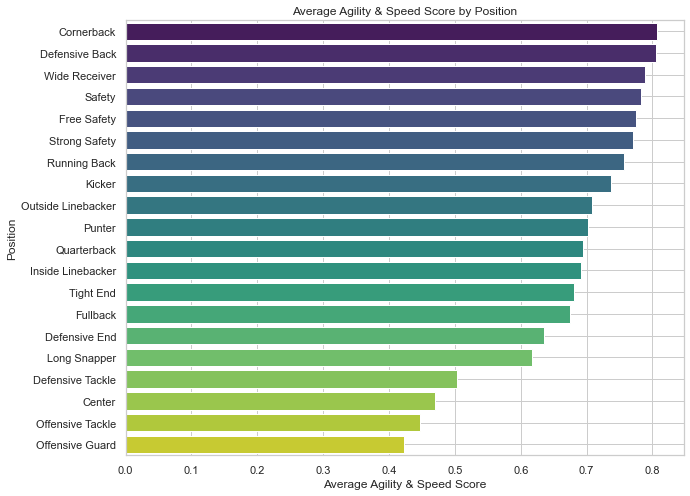

In [35]:
# Group by 'Position_Type' and calculate the mean of the 'Composite_Score_Player' for each position
position_agspeed_means = df.groupby('Position')['Agility_Speed_Score'].mean().reset_index()

# Sort the positions by their average composite score in descending order
position_agspeed_means = position_agspeed_means.sort_values(by='Agility_Speed_Score', ascending=False)

df = df.merge(position_agspeed_means, on='Position', suffixes=('', '_Position_Avg'))

plt.figure(figsize=(10, 8))

# Draw a seaborn barplot for Strength Score
sns.barplot(x='Agility_Speed_Score', y='Position', data=position_agspeed_means, palette='viridis')

plt.xlabel('Average Agility & Speed Score')
plt.ylabel('Position')
plt.title('Average Agility & Speed Score by Position')
plt.grid(True)

plt.show()


#### <b>Position-Specific:</b> Best at Jumping Drills

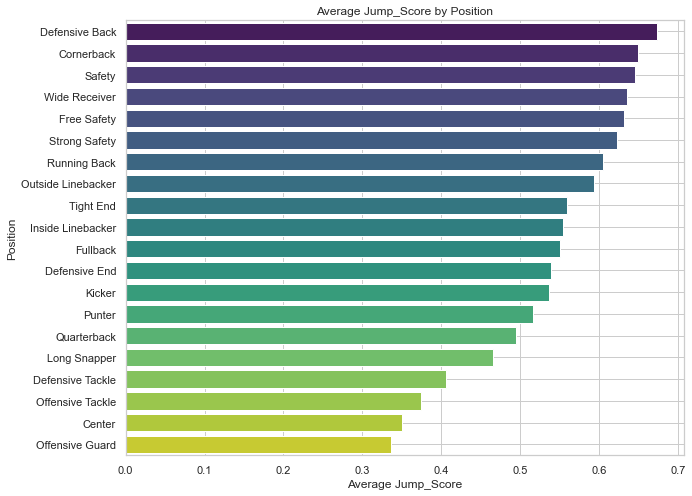

In [36]:
# Group by 'Position_Type' and calculate the mean of the 'Composite_Score_Player' for each position
position_jump_means = df.groupby('Position')['Jump_Score'].mean().reset_index()

# Sort the positions by their average composite score in descending order
position_jump_means = position_jump_means.sort_values(by='Jump_Score', ascending=False)
df = df.merge(position_jump_means, on='Position', suffixes=('', '_Position_Avg'))

plt.figure(figsize=(10, 8))

# Draw a seaborn barplot for Strength Score
sns.barplot(x='Jump_Score', y='Position', data=position_jump_means, palette='viridis')

plt.xlabel('Average Jump_Score')
plt.ylabel('Position')
plt.title('Average Jump_Score by Position')
plt.grid(True)

plt.show()



#### <b> Strongest Feat by Position</b>

We determine the strongest feat by position by looking at the average score by position. We select the highest of these scorres. For instance, Defensive Guards will have a better strength score than agility/speed score. We select strength as the strongest position feat. 

In [37]:
import pandas as pd

# Assuming 'df' is your DataFrame

# Group by 'Position' and calculate the mean for each score category
position_means = df.groupby('Position').agg({
    'Strength_Score': 'mean',
    'Jump_Score': 'mean',
    'Agility_Speed_Score': 'mean'
}).reset_index()

# Determine the strongest feat for each position
def determine_strongest_feat(row):
    feats = {
        'Strength_Score': row['Strength_Score'],
        'Jump_Score': row['Jump_Score'],
        'Agility_Speed_Score': row['Agility_Speed_Score']
    }
    return max(feats, key=feats.get)

# Apply the function to each row to create a new column
position_means['Strongest_Feat_Position'] = position_means.apply(determine_strongest_feat, axis=1)

# Merge the 'Strongest_Feat' back into the original DataFrame
df = df.merge(position_means[['Position', 'Strongest_Feat_Position']], on='Position', how='left')



<b> Stacked Bar Chart for Best Feat by Position</b>

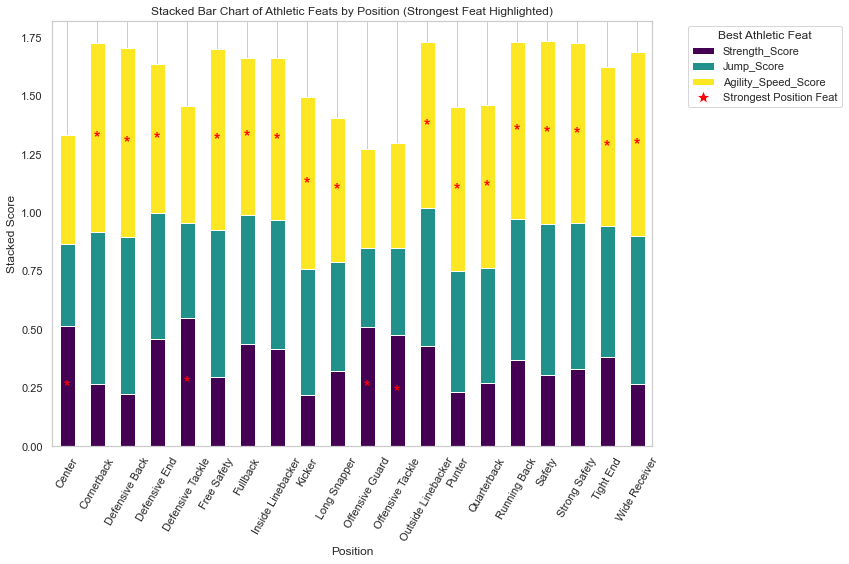

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Assuming 'position_means' is your DataFrame with the relevant data

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Plot a stacked bar chart
ax = position_means.set_index('Position')[['Strength_Score', 'Jump_Score', 'Agility_Speed_Score']].plot(
    kind='bar',
    stacked=True,
    colormap='viridis',
    figsize=(12, 8),
    ax=plt.gca()
)

# Highlight the strongest feat by position with annotations
for idx, row in position_means.iterrows():
    max_feat = row['Strongest_Feat_Position']
    max_feat_value = row[max_feat]
    # Calculate the position to place the annotation
    y_offset = row[['Strength_Score', 'Jump_Score', 'Agility_Speed_Score']].cumsum()[max_feat]
    # Add a star marker or annotation to highlight the strongest feat
    ax.text(idx, y_offset - max_feat_value / 2, '*', ha='center', va='center', color='red', fontsize=16, fontweight='bold')

# Customize the legend manually
handles, labels = ax.get_legend_handles_labels()

# Create a custom legend with the red asterisk only (no rectangle)
legend_elements = [
    Patch(facecolor='#440154', label='Strength_Score'),
    Patch(facecolor='#21918c', label='Jump_Score'),
    Patch(facecolor='#fde725', label='Agility_Speed_Score'),
    Line2D([0], [0], marker='*', color='w', label='Strongest Position Feat', markersize=15, markerfacecolor='red', linestyle='None')
]

# Position the legend outside the plot area
ax.legend(handles=legend_elements, title='Best Athletic Feat', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xlabel('Position')
plt.ylabel('Stacked Score')
plt.xticks(rotation=60)
plt.title('Stacked Bar Chart of Athletic Feats by Position (Strongest Feat Highlighted)')
plt.grid(axis='y')
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()


<b>Scatterplot for Best Feat Score </b><br>The clusters highlighted in our scatterplot highlights that players will tend to have a be better at certain athletic feat, based on their position. Although some positions, like Defensive Ends for instance, will be slightly more balanced in terms of score, as opposed to Quarterbacks.

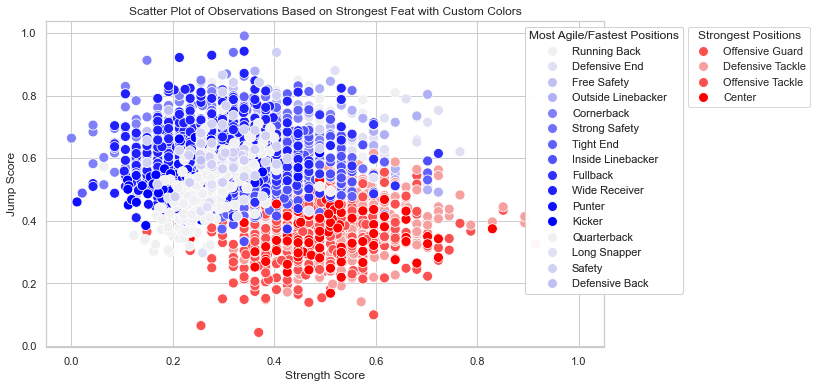

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming the existing data and plot setup

# Step 1: Create a custom color palette
strength_colors = sns.light_palette("red", n_colors=len(df[df['Strongest_Feat_Position'] == 'Strength_Score']['Position'].unique()))
agility_colors = sns.light_palette("blue", n_colors=len(df[df['Strongest_Feat_Position'] == 'Agility_Speed_Score']['Position'].unique()))

# Create a dictionary for the colors
color_mapping = {}
for i, position in enumerate(df['Position'].unique()):
    if df.loc[df['Position'] == position, 'Strongest_Feat_Position'].iloc[0] == 'Strength_Score':
        color_mapping[position] = strength_colors[i % len(strength_colors)]
    elif df.loc[df['Position'] == position, 'Strongest_Feat_Position'].iloc[0] == 'Agility_Speed_Score':
        color_mapping[position] = agility_colors[i % len(agility_colors)]

df_plot = df
# Map colors to the DataFrame
df_plot['Color'] = df_plot['Position'].map(color_mapping)

# Step 2: Create a scatter plot to visualize the clusters based on the strongest feat
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(
    x='Strength_Score', 
    y='Jump_Score', 
    hue='Position', 
    palette=color_mapping, 
    data=df_plot, 
    s=100,
    legend=False  # Disable the default legend
)

# Step 3: Manually create the legend for Strength
strength_positions = df_plot[df_plot['Strongest_Feat_Position'] == 'Strength_Score']['Position'].unique()
handles_strength = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[pos], markersize=10, label=pos) 
                    for pos in strength_positions]
legend_strength = ax.legend(handles=handles_strength, title='Strength Feat', loc='upper center', bbox_to_anchor=(1.3, 1))

# Step 4: Manually create the legend for Agility/Speed
agility_positions = df_plot[df_plot['Strongest_Feat_Position'] == 'Agility_Speed_Score']['Position'].unique()
handles_agility = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[pos], markersize=10, label=pos) 
                   for pos in agility_positions]
# Add the first legend for Strength Feat
legend_strength = ax.legend(handles=handles_strength, title='Strongest Positions', loc='upper center', bbox_to_anchor=(1.26, 1))

# Add the second legend for Agility/Speed Feat, placing it right next to the first legend
# The x-coordinate of bbox_to_anchor for the second legend should be adjusted
# The adjustment depends on the size of the first legend, you might need to tweak it
legend_agility = ax.legend(handles=handles_agility, title='Most Agile/Fastest Positions', loc='upper center', bbox_to_anchor=(1.0, 1))

# Add both legends to the plot
ax.add_artist(legend_strength)
ax.add_artist(legend_agility)

# Customize the plot
plt.title('Scatter Plot of Observations Based on Strongest Feat with Custom Colors')
plt.xlabel('Strength Score')
plt.ylabel('Jump Score')
plt.grid(True)
plt.show()

### <b>Relative Metrics for Athleticism</b>

#### <b>Relative Metric: Z-Score by Position</b>

The Z-score effectively measures relative player athleticism within a position by standardizing each player’s performance against their peers, highlighting how much they outperform or underperform others in the same role. This enables clear identification of standout or weaker athletes within the same position group. In the <b>Boxplots</b> below, we find that Drafted Players will tend to have higher scores than non-drafted players in most Athleticism Scores. This shows that their relative athleticism is higher. 

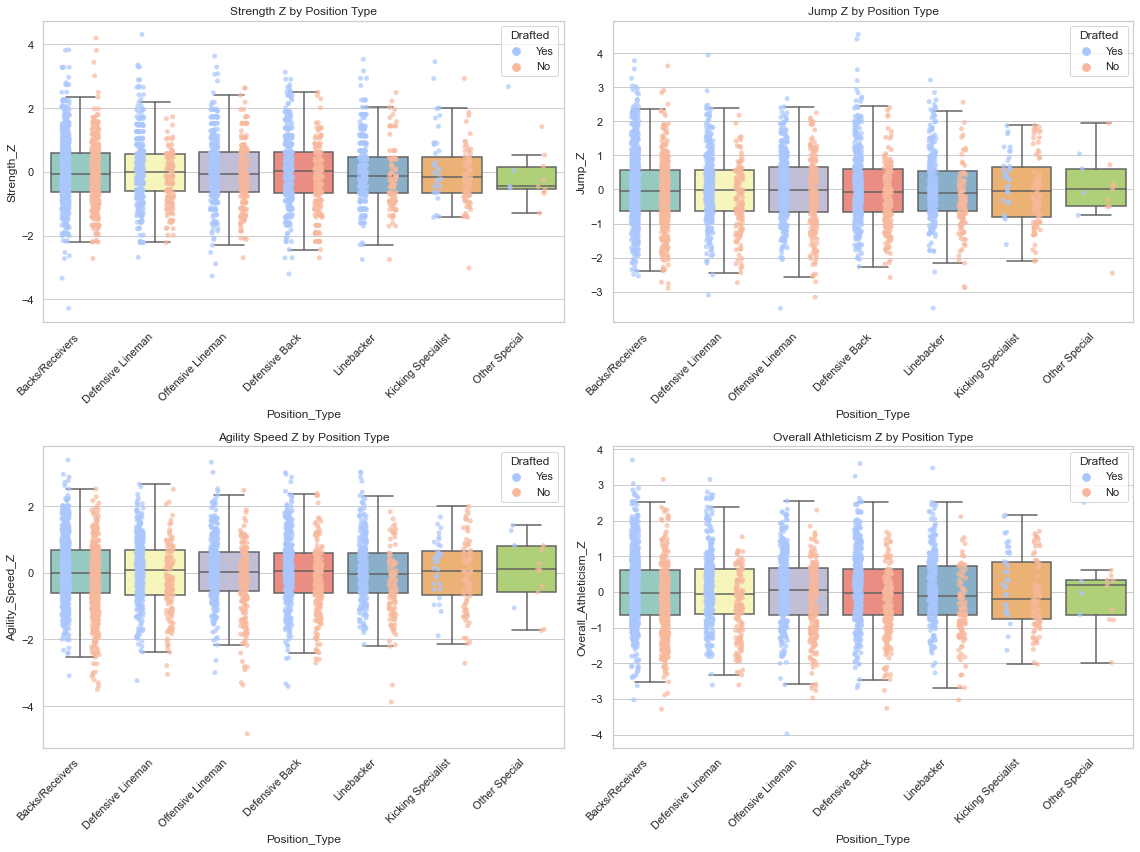

In [40]:
import pandas as pd
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame

# Step 1: Calculate the z-scores for each position group
df['Strength_Z'] = df.groupby('Position')['Strength_Score'].transform(lambda x: zscore(x, nan_policy='omit'))
df['Jump_Z'] = df.groupby('Position')['Jump_Score'].transform(lambda x: zscore(x, nan_policy='omit'))
df['Agility_Speed_Z'] = df.groupby('Position')['Agility_Speed_Score'].transform(lambda x: zscore(x, nan_policy='omit'))
df['Overall_Athleticism_Z'] = df.groupby('Position')['Overall_Athleticism'].transform(lambda x: zscore(x, nan_policy='omit'))

# Step 2: Visualization of Z-Scores by Position Type

# Set up the figure and axes
plt.figure(figsize=(16, 12))

# List of score types to plot
score_types = ['Strength_Z', 'Jump_Z', 'Agility_Speed_Z', 'Overall_Athleticism_Z']

# Create a boxplot and stripplot for each score type
for i, score_type in enumerate(score_types):
    plt.subplot(2, 2, i + 1)  # 2 rows, 2 columns, subplot i+1
    
    # Boxplot for the score type
    sns.boxplot(x='Position_Type', y=score_type, data=df, palette='Set3', showfliers=False)
    
    # Stripplot to overlay data points, colored by 'Drafted' status
    sns.stripplot(x='Position_Type', y=score_type, data=df, hue='Drafted', dodge=True, jitter=True, palette='coolwarm', marker='o', alpha=0.7)
    
    plt.title(f'{score_type.replace("_", " ")} by Position Type')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Drafted', loc='best')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


#### Relative Metric: Schools Player Performance Z-Score Average

In [41]:
df['Strongest_Feat_Z'] = df.lookup(df.index, df['Strongest_Feat_Position'])

# Step 2: Calculate the average Z-score for each school based on the strongest feat Z-score
school_avg_z_scores = df.groupby('School')['Strongest_Feat_Z'].mean().sort_values(ascending=False)

# Step 3: Create a DataFrame to hold the average Z-scores
school_avg_z_scores_df = school_avg_z_scores.reset_index()
school_avg_z_scores_df.columns = ['School', 'School_Average_Z_Score']

# Step 4: Merge the average Z-scores back into the original DataFrame
df = df.merge(school_avg_z_scores_df, on='School', how='left')


/var/folders/qz/2_cjtz1d25729cwclbl0hk640000gn/T/ipykernel_18987/2905291853.py:1: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
  df['Strongest_Feat_Z'] = df.lookup(df.index, df['Strongest_Feat_Position'])


<b> School Size:</b> When looking at how a good a school is, we identify how good players are in relation to their position's best athletic performance. Using this metric, we find little to no correlation between the school size, and the relative athletic competence.

In [42]:
df['Drafted_Num'] = df['Drafted'].map({'No': 0, 'Yes': 1})

# Step 1: Calculate the school size (number of players per school)
school_size = df.groupby('School').size().reset_index(name='School_Size')

# Step 2: Merge school size and average Z-score into a single DataFrame
school_metrics = df.merge(school_size, on='School', how='left').drop_duplicates(subset=['School'])
school_metrics = school_metrics[['School', 'School_Size', 'School_Average_Z_Score']]

# Step 3: Calculate the Pearson correlation coefficient
correlation, p_value = pearsonr(school_metrics['School_Size'], school_metrics['School_Average_Z_Score'])

# Display the correlation result
print(f"Pearson correlation between school size and average Z-score: {correlation:.2f}")
print(f"P-value: {p_value:.4f}")

# Step 4: Visualize the relationship with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='School_Size', y='School_Average_Z_Score', data=school_metrics, scatter_kws={'s': 50}, line_kws={'color': 'red'})
plt.title('Correlation between School Size and Relative Player Position Best Feat Z-Score')
plt.xlabel('School Size (Number of Players)')
plt.ylabel('Average Z-Score')
plt.show()


NameError: name 'pearsonr' is not defined

<b>School Size and Drafted Status</b><br>We find that the school size does have a slight position relationship with the proportion of players getting drafted

Pearson correlation between school size and proportion of players drafted: 0.21
P-value: 0.0006


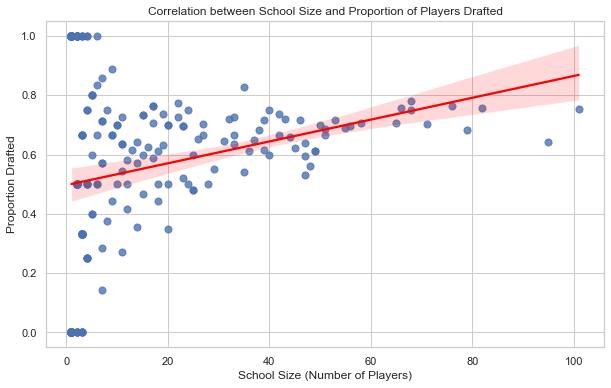

In [ ]:
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your DataFrame

# Step 1: Calculate the number of players from each school
school_size = df.groupby('School').size().reset_index(name='School_Size')

# Step 2: Calculate the number of players drafted from each school
drafted_per_school = df.groupby('School')['Drafted_Num'].sum().reset_index(name='Drafted_Count')

# Step 3: Merge the school size and drafted count
school_metrics = pd.merge(school_size, drafted_per_school, on='School')

# Step 4: Calculate the proportion of players drafted
school_metrics['Proportion_Drafted'] = school_metrics['Drafted_Count'] / school_metrics['School_Size']

# Step 5: Calculate the Pearson correlation coefficient
correlation, p_value = pearsonr(school_metrics['School_Size'], school_metrics['Proportion_Drafted'])

# Display the correlation result
print(f"Pearson correlation between school size and proportion of players drafted: {correlation:.2f}")
print(f"P-value: {p_value:.4f}")

# Step 6: Visualize the relationship with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='School_Size', y='Proportion_Drafted', data=school_metrics, scatter_kws={'s': 50}, line_kws={'color': 'red'})
plt.title('Correlation between School Size and Proportion of Players Drafted')
plt.xlabel('School Size (Number of Players)')
plt.ylabel('Proportion Drafted')
plt.show()


#### <b>Relationship between Position Z-Score and Drafted Status</b>

<b> Correlation:</b> Position Z-Score Correlation by Position <br>
The Pair Plot shows that position relative jump performance is highly correlated with athleticism. In accordance with the previous boxplots, we also find that position-relative Overall Athleticism will be the most important performance score for a player to get drafted; with mild positive correlation. Additionally, any feat of ahtleticism will show a slight positive correlation with the drafted status. Surprisingly, we find that School Average Relativre Z-Score Average has little correlation with being Drafted.

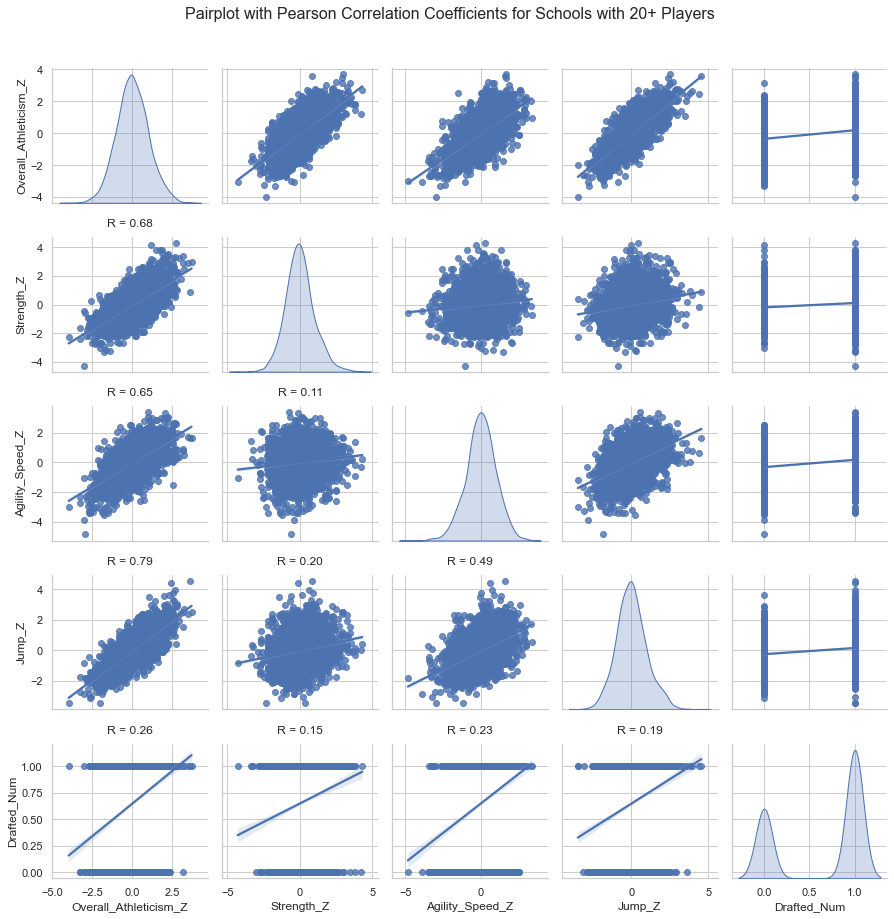

In [ ]:
# Step 2: Define the relevant columns for the pairplot
correlation_columns = ['Overall_Athleticism_Z', 'Strength_Z', 'Agility_Speed_Z', 'Jump_Z', 'Drafted_Num']

# Step 3: Create the pairplot using the filtered DataFrame
pairplot = sns.pairplot(df[correlation_columns], kind="reg", diag_kind="kde")

# Step 4: Adding Pearson correlation coefficients on top of each subplot
for i, j in zip(*np.tril_indices_from(pairplot.axes, -1)):
    ax = pairplot.axes[i, j]
    corr = df[correlation_columns[i]].corr(df[correlation_columns[j]])
    ax.annotate(f'R = {corr:.2f}', xy=(0.5, 1.1), xycoords='axes fraction', ha='center', va='center', fontsize=12)

# Step 5: Customize the plot
plt.suptitle('Pairplot with Pearson Correlation Coefficients for Schools with 20+ Players', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()


### Summary Statistics: Who is the Best?

First, we find the strongest feat by position. This enables us to find the best entity, according to the position standards. For instance, Defensive Guards have Strength as their highest average athletic Feat, and will be expected to be stronger than other positions. Using the Position-Relative Z-Score, we find the best entity according to the position standards.

<b> Most Athletic Player according to their Position's Best Athletic Feat:</b> Stephen Paea

In [ ]:

# Determine the Z-score to use based on the 'Strongest_Feat_Position' column
df['Strongest_Feat_Z'] = np.where(
    df['Strongest_Feat_Position'] == 'Agility_Speed_Score',
    df['Agility_Speed_Z'],
    df['Strength_Z']
)

# Find the player with the highest Z-score for their strongest feat
max_z_score_row = df.loc[df['Strongest_Feat_Z'].idxmax()]

# Display the player details with the highest Z-score
print(max_z_score_row[['Player', 'Position', 'Strongest_Feat_Position', 'Strongest_Feat_Z']])

Player                         Stephen Paea
Position                   Defensive Tackle
Strongest_Feat_Position      Strength_Score
Strongest_Feat_Z                   4.307585
Name: 1123, dtype: object


<b> Best Round:</b> Round 1

In [ ]:
import pandas as pd

# Assuming 'df' is your DataFrame and already contains the 'Composite_Score' column

# List of the columns to analyze
columns_to_analyze = ['Strength_Z', 'Jump_Z', 'Agility_Speed_Z', 'Overall_Athleticism_Z']

# Group by 'Round' and calculate the mean for each of the selected columns
round_means = df.groupby('Round')[columns_to_analyze ].mean()

# Create a DataFrame to display all rounds and their mean scores
round_scores_df = round_means.reset_index()

# Sort the DataFrame by the composite score in descending order
round_scores_df = round_scores_df.sort_values(by='Overall_Athleticism_Z', ascending=False)


round_scores_df.head(10)  # Display the top 10 rounds


,Round,Strength_Z,Jump_Z,Agility_Speed_Z,Overall_Athleticism_Z
0,1,0.313529,0.519500,0.554278,0.620303
1,2,0.177626,0.271967,0.191178,0.303747
2,3,0.076086,0.195126,0.221278,0.224517
3,4,0.091860,0.130851,0.156881,0.172311
4,5,0.076282,-0.048006,0.074556,0.029323
5,6,-0.004175,-0.072788,-0.029910,-0.041442
6,7,-0.011710,-0.073516,-0.039521,-0.057250
7,8,-0.198749,-0.262677,-0.316590,-0.351093


<b> Best Team</b>

In [ ]:

# Calculate the average Z-score for each team
team_avg_z_scores = df.groupby('Team')['Strongest_Feat_Z'].mean().sort_values(ascending=False)

# Display the teams ranked by their average Z-score
team_avg_z_scores[:1]

Team
New York Giants    0.341626
Name: Strongest_Feat_Z, dtype: float64

<b> Best School</b>

In [ ]:
import pandas as pd
from scipy.stats import pearsonr

# Assuming df is your DataFrame
df_test = df.copy()

# Step 1: Calculate the average Z-score for each school
school_avg_z_scores = df_test.groupby('School')['Strongest_Feat_Z'].mean()

# Step 2: Calculate the draft rate for each school
df_test['Drafted_Num'] = df_test['Drafted'].apply(lambda x: 1 if x == 'Yes' else 0)
school_draft_rate = df_test.groupby('School')['Drafted_Num'].mean()

# Step 3: Merge the two metrics into a single DataFrame
school_metrics = pd.DataFrame({
    'Average_Z_Score': school_avg_z_scores,
    'Draft_Rate': school_draft_rate
})

# Step 4: Rank schools by Average Z-Score and Draft Rate
school_metrics['Z_Score_Rank'] = school_metrics['Average_Z_Score'].rank(ascending=False)
school_metrics['Draft_Rate_Rank'] = school_metrics['Draft_Rate'].rank(ascending=False)

# Step 5: Calculate an overall rank by averaging the ranks of Z-Score and Draft Rate
school_metrics['Overall_Rank'] = (school_metrics['Z_Score_Rank'] + school_metrics['Draft_Rate_Rank']) / 2
school_metrics = school_metrics.sort_values('Overall_Rank')

# Display the top-ranked school
best_school = school_metrics.head(1)
print(f"Best School: \n{best_school}")

# Step 6: Calculate the Pearson correlation coefficient
correlation, p_value = pearsonr(school_metrics['Average_Z_Score'], school_metrics['Draft_Rate'])

# Display the correlation result
print(f"Pearson correlation between average Z-score and draft rate: {correlation:.2f}")
print(f"P-value: {p_value:.4f}")

school_metrics['Draft_Rate_Rank']


Best School: 
                   Average_Z_Score  Draft_Rate  Z_Score_Rank  Draft_Rate_Rank  \
School                                                                          
Missouri Southern          2.07546         1.0           1.0             24.0   

                   Overall_Rank  
School                           
Missouri Southern          12.5  
Pearson correlation between average Z-score and draft rate: 0.27
P-value: 0.0000


School
Missouri Southern         24.0
Saginaw Valley St.        24.0
Mount Union               24.0
Ark-Pine Bluff            24.0
NW State (LA)             24.0
                         ...  
Northern Colorado        229.5
Sioux Falls              229.5
Murray St.               229.5
Northwestern St. (LA)    229.5
Alcorn St.               229.5
Name: Draft_Rate_Rank, Length: 253, dtype: float64

### Summary Statistics: Who is the Worst?

Worst Player

In [ ]:
# Find the player with the lowest Z-score for their strongest feat
worst_player_row = df.loc[df['Strongest_Feat_Z'].idxmin()]

# Display the details of the worst player
print(f"Worst Player: \n{worst_player_row[['Player', 'Team', 'Position', 'School', 'Strongest_Feat_Position', 'Strongest_Feat_Z']]}")


Worst Player: 
Player                           Wayne Daniels
Team                               Not Drafted
Position                    Outside Linebacker
School                                     TCU
Strongest_Feat_Position    Agility_Speed_Score
Strongest_Feat_Z                     -3.875295
Name: 1044, dtype: object


Worst Team

In [ ]:
# Calculate the average Z-score for each team
team_avg_z_scores = df.groupby('Team')['Strongest_Feat_Z'].mean().sort_values(ascending=False)

# Display the teams ranked by their average Z-score
team_avg_z_scores.tail(2)

Team
New York Jets   -0.166792
Not Drafted     -0.294327
Name: Strongest_Feat_Z, dtype: float64

# 5. Model Pre-Processing

#### <b>Variable Selection and Train-Test Split:</b>

Dropping irrelevant columns

In [43]:
df = df.drop(columns=['Age','Player','Round', 'Team', 'Year', 'Pick','Upper_Bound_Outlier', 'Lower_Bound_Outlier','Drafted',
'Overall_Athleticism_Position_Avg', 'Strength_Score_Position_Avg', 'Agility_Speed_Score_Position_Avg', 'Jump_Score_Position_Avg', 'Color'])

In [44]:
categorical_cols = [col for col in df.columns if df[col].dtype == "object"]
df[categorical_cols] = df[categorical_cols].apply(lambda x: x.astype('category'))

In [45]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=['Drafted_Num'])  # Features
y = df['Drafted_Num']  # Target
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### <b>Dealing with Class Imbalance</b>

As previously highlighted, the target variable has 2254 Players who were drafted, and 1223 who were rejected from the draft.

In [46]:
from collections import Counter
from matplotlib import pyplot
from numpy import where
# summarize class distribution
counter = Counter(y)
print(counter)


Counter({1: 2254, 0: 1223})


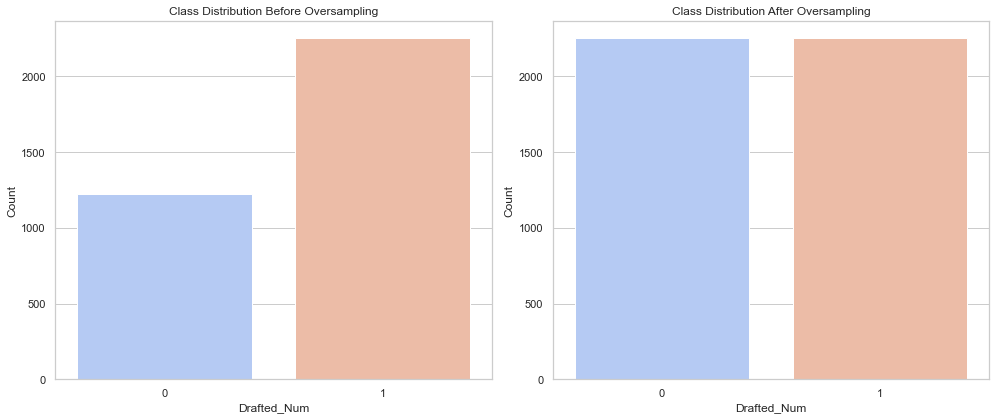

In [47]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Step 1: Encode categorical features to numeric
# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# Apply LabelEncoder or OneHotEncoder as needed
# LabelEncoding for simplicity here, although OneHotEncoder is more typical for categorical features
X_encoded = X.copy()
for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col])

# Step 2: Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded, y)

# Step 3: Visualize the class distribution before and after oversampling
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Original class distribution
sns.countplot(x=y, palette='coolwarm', ax=ax[0])
ax[0].set_title('Class Distribution Before Oversampling')
ax[0].set_xlabel('Drafted_Num')
ax[0].set_ylabel('Count')

# Resampled class distribution
sns.countplot(x=y_resampled, palette='coolwarm', ax=ax[1])
ax[1].set_title('Class Distribution After Oversampling')
ax[1].set_xlabel('Drafted_Num')
ax[1].set_ylabel('Count')

plt.tight_layout()
plt.show()


# 6. XGBoost Model

In [48]:
import xgboost as xgb

# Create DMatrix for training and testing
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

We will need to change our categorical variables to numerical format to fit the model and therefore we will identify of the comlumsn are categorical.

We identify 4 categorical featues and will encode them as part of the one of the pre processing steps to train the model

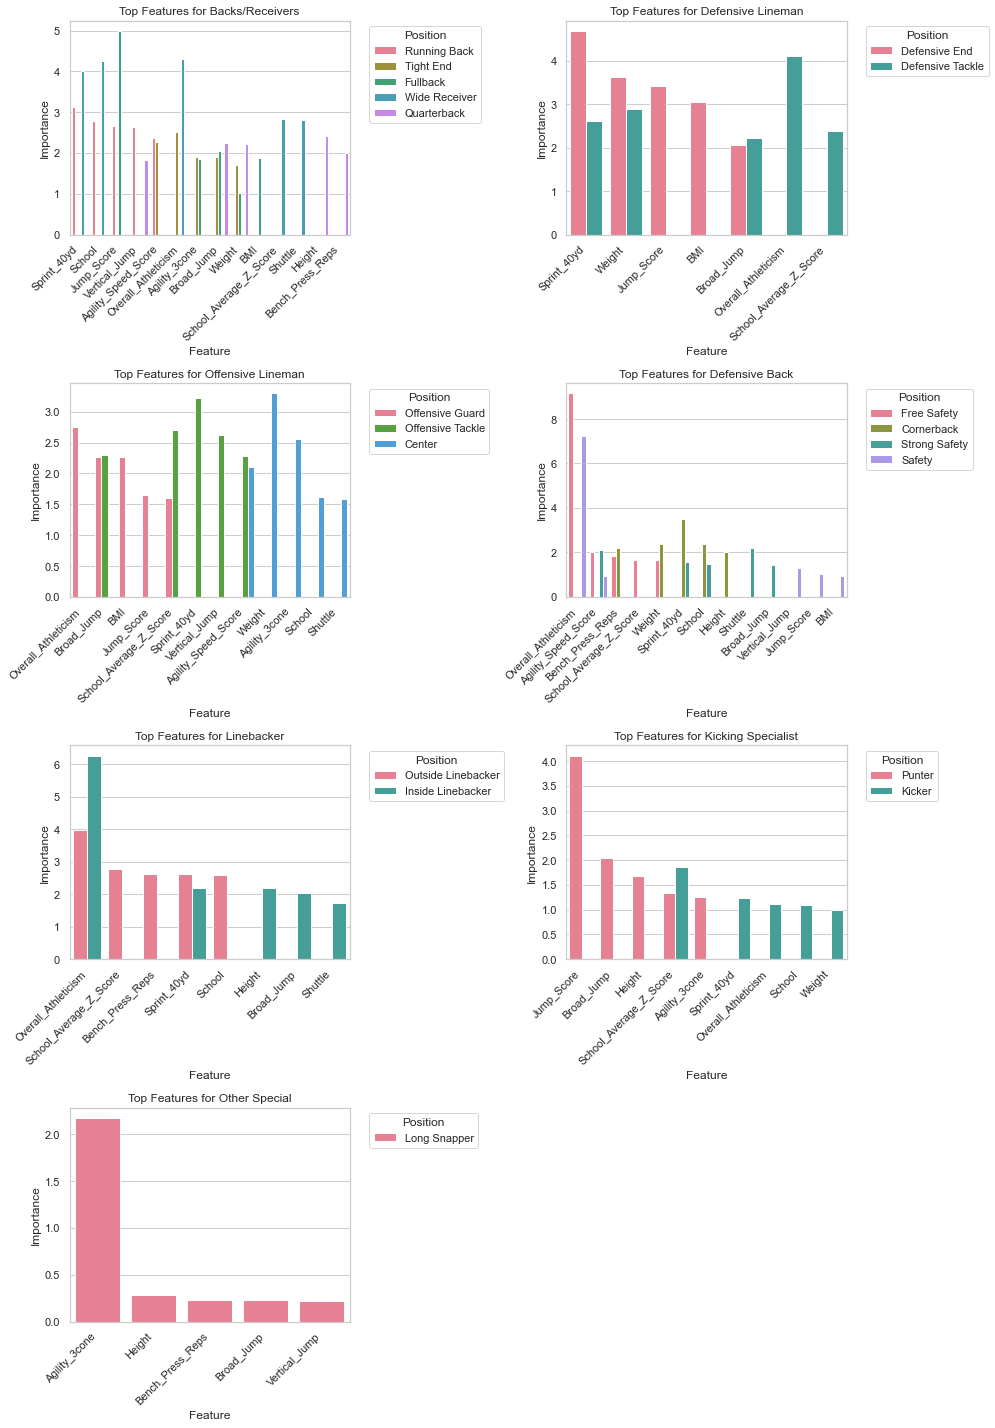

In [52]:
# Assuming df_cleaned is your DataFrame and 'Drafted_Num' is your target variable
position_types = df['Position_Type'].unique()
top_features = {}

# Step 1: Collecting top features for each position type
for position_type in position_types:
    # Filter the data for the specific position type
    df_position_type = df[df['Position_Type'] == position_type]

    # Collect top features for each position within the position type
    positions = df_position_type['Position'].unique()
    for position in positions:
        df_position = df_position_type[df_position_type['Position'] == position]

        # Define the features (X) and target (y)
        X = df_position.drop(columns=['Drafted_Num', 'Position', 'Position_Type'])
        y = df_position['Drafted_Num']

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Convert to DMatrix
        dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
        dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

        # Set XGBoost parameters
        params = {
            'objective': 'binary:logistic',
            'max_depth': 6,
            'eta': 0.3,
            'eval_metric': 'logloss'
        }

        # Train the model
        model = xgb.train(params, dtrain, num_boost_round=100, evals=[(dtest, "Test")], early_stopping_rounds=10, verbose_eval=False)

        # Get feature importances
        feature_importance = model.get_score(importance_type='gain')

        # Sort and get top 5 features
        sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
        top_features[position] = sorted_features[:5]

# Step 2: Preparing data for visualization
data = []
for position, features in top_features.items():
    for feature, importance in features:
        data.append({'Position': position, 'Feature': feature, 'Importance': importance})

df_visualization = pd.DataFrame(data)

# Step 3: Visualization by Position_Type

# Setting Seaborn color palette
sns.set_palette("husl")

# Plotting the top features for each position type
plt.figure(figsize=(14, 20))
position_types = df['Position_Type'].unique()

for i, position_type in enumerate(position_types, 1):
    plt.subplot((len(position_types) + 1) // 2, 2, i)
    subset = df_visualization[df_visualization['Position'].isin(df[df['Position_Type'] == position_type]['Position'].unique())]
    sns.barplot(x='Feature', y='Importance', hue='Position', data=subset, palette='husl')
    plt.title(f'Top Features for {position_type}')
    plt.ylabel('Importance')
    plt.xlabel('Feature')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels diagonally
    plt.legend(title='Position', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
